#Scelta parametri
Dalla ricerca con le immagini 128x64 e 512x64, è emerso che se l'immagine è 512x64, ottengo risultati migliori.

Questo può essere dovuto al fatto che ho più dati e che non rendono più complesso il problema di riconoscimento.

Il numero di time steps migliore è 64; meno e potrei avere accuratezza leggermente peggiore, di più e risulta "troppo", aumentando il numero di epoche per raggiungere un'accuratezza finale simile 64 time steps.

Se ho un'immagine 512x64 ed indico 64 come time steps, tanto vale indicare l'immagine come 64x512; il problema non si pone sulla forma dell'immagine, in quanto la rete LSTM legge valori nella forma dei time steps.

* 64x512, con 64 time steps;
* 64x128, con 64 time steps.

##Descrizione

In questo notebook viene implementata una rete neurale LSTM.

Sono implementati 2+1 modelli, uno con immagini croppate nella dimensione 64x512 e l'altro con immagini croppate nella dimensione 64x128; l'ultimo modello ha immagini croppate a 64x64, e notiamo il peggioramento nelle prestazioni.

Sono presenti grafici circa la validation accuracy, validation loss, confusion matrix e grafici che analizzano gli errori di classificazione: per lista offuscamento applicata, per lista offuscamento ignorando l'ordine degli offuscamenti, per classe e per offuscamento applicato in percentuale al numero di offuscamenti effettuati.

In fondo al notebook vi è un grafo che mostra la validation accuracy dei tre modelli a confronto.

Parametri:

database_scelto = '18k', croppato.

batch_size = 512

num_units1 = 141

num_units2 = 94

channels = 1

n_epochs = 100

patience = 10

(Risultati medi)

#64x512
64x512: Accuratezza 92,62%, 59 epochs, 419,91s.
* ('EncodeArithmetic-Flatten-RandomFuns', 24)
* ('Flatten-RandomFuns-Split', 23)
* ('EncodeLiterals-RandomFuns-Split', 15)

##64x128
64x128: Accuratezza 93,52%, 100 epochs, 776.26s.
* ('Flatten-RandomFuns-Split', 26)
* ('EncodeArithmetic-Flatten-RandomFuns', 16)
* ('EncodeArithmetic-RandomFuns-Split', 13)

##64x64
64x64: Accuratezza 84,41%, 80 epochs, 316.15s.
* ('Flatten-RandomFuns-Split', 32)
* ('EncodeArithmetic-Flatten-RandomFuns', 25)
* ('EncodeArithmetic-InitOpaque-RandomFuns', 22)

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Import

In [2]:
import tensorflow as tf
from tensorflow import keras as ks


import numpy as np
import pandas as pd

import time
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
'''
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
#from tensorflow.keras.layers import Dropout
#from tensorflow.keras.layers import Conv2D
'''
print(tf.__version__)

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Parametri modello 1 64x512

In [3]:
database_scelto = '18k' #or '14k' or '9k'

dim1 = 64
dim2 = 512
batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = dim1
n_features = dim2

n_epochs = 100
patience = 10

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
!git clone https://github.com/PaoloDarienzo/NN_modules.git
!mv NN_modules/Defining_Methods.py /content
!rm -rf NN_modules

Cloning into 'NN_modules'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 102 (delta 10), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (102/102), 2.80 MiB | 5.00 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [6]:
import Defining_Methods as my_lib

In [8]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

18800
START IMAGE INPUT
END IMAGE INPUT


In [9]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

##Modello 1

In [10]:
modelLSTM, hist, time_callback = my_lib.modelLSTM(num_units1, num_units2, time_steps, n_features, batch_size, n_classes, patience, sub_db, n_epochs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


##Risultati modello 1

In [11]:
number_of_epochs_it_ran = len(hist.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)

test_accuracy = modelLSTM.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

3008/3008 [==============================] - 5s 2ms/sample - loss: 0.4794 - acc: 0.9066
Total epochs 62
282.96312642097473 s


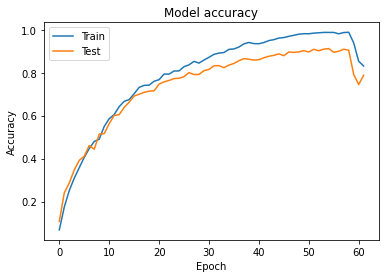

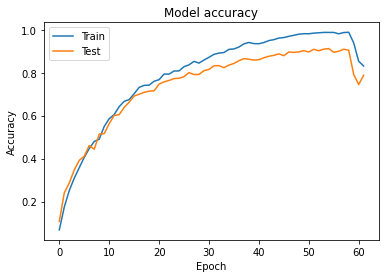

In [12]:
modelAcc1 = my_lib.plot_model_acc(hist)
modelLoss1 = my_lib.plot_model_acc(hist)

plt.show(modelAcc1)
plt.show(modelLoss1)

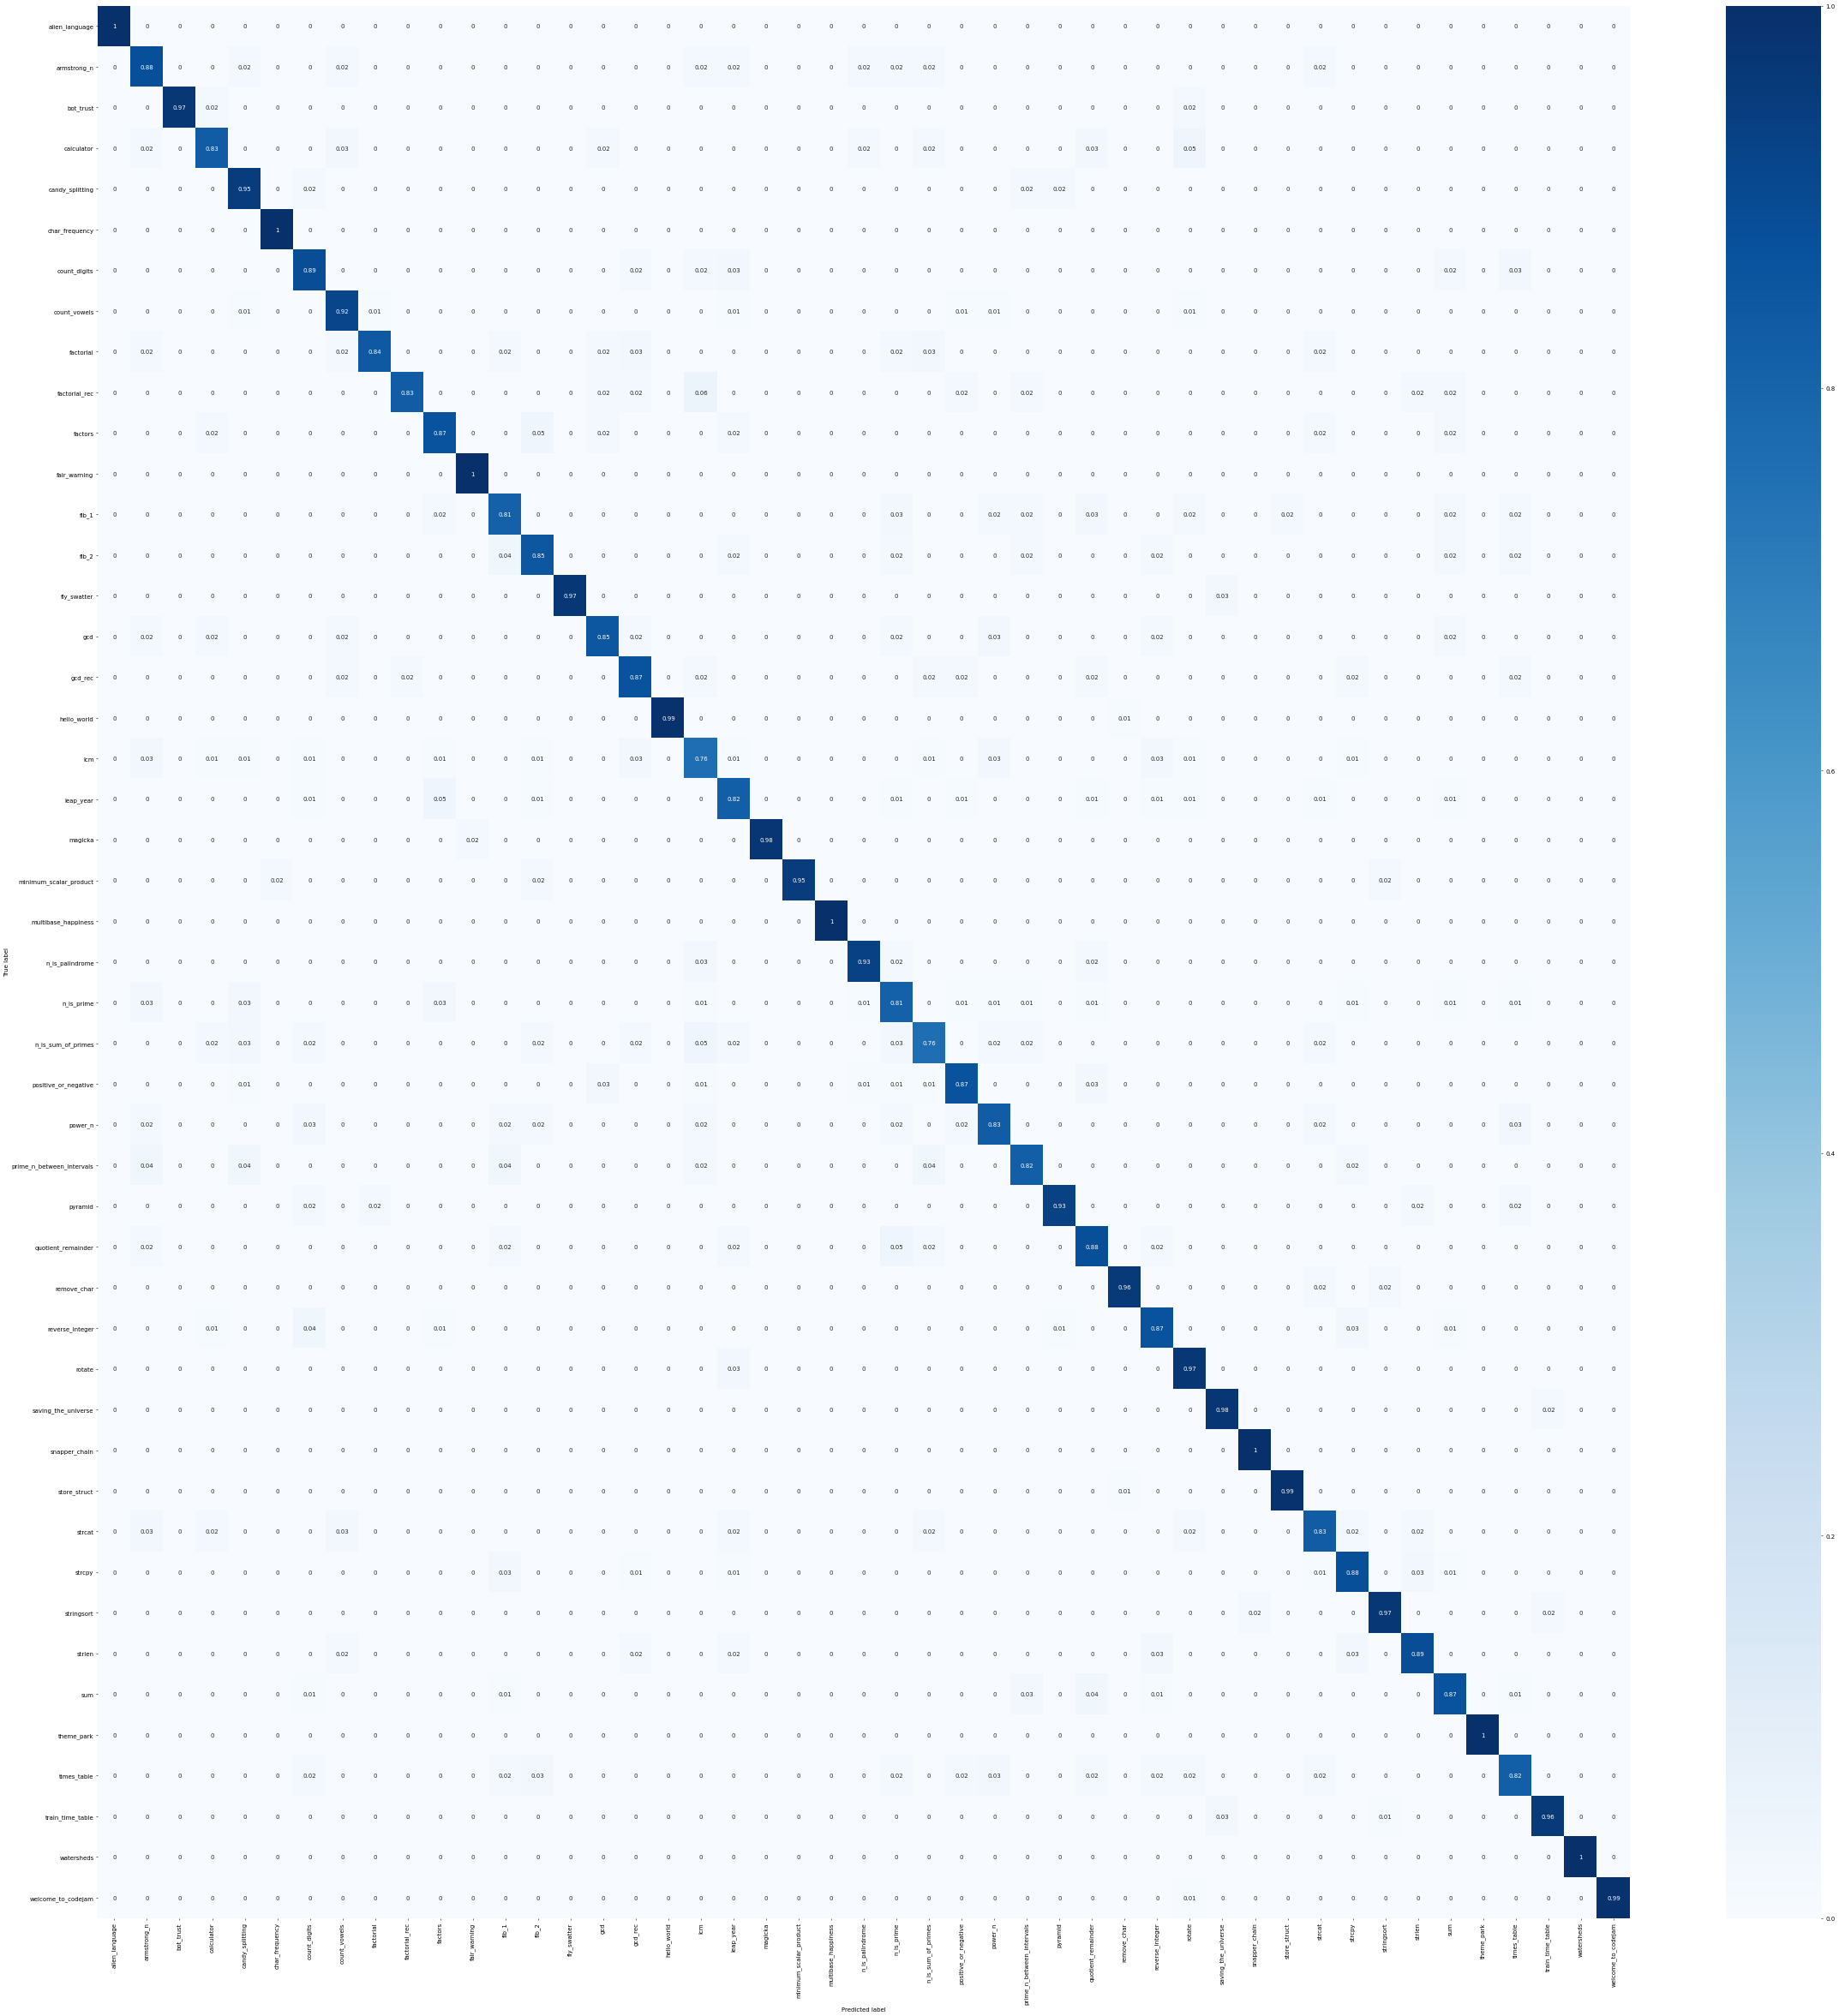

In [13]:
confMat1 = my_lib.plot_conf_matrix(modelLSTM, validation_images, validation_labels_encoded, label_encoder)
plt.show(confMat1)

Grafo degli errori focalizzato sul singolo set di offuscamento


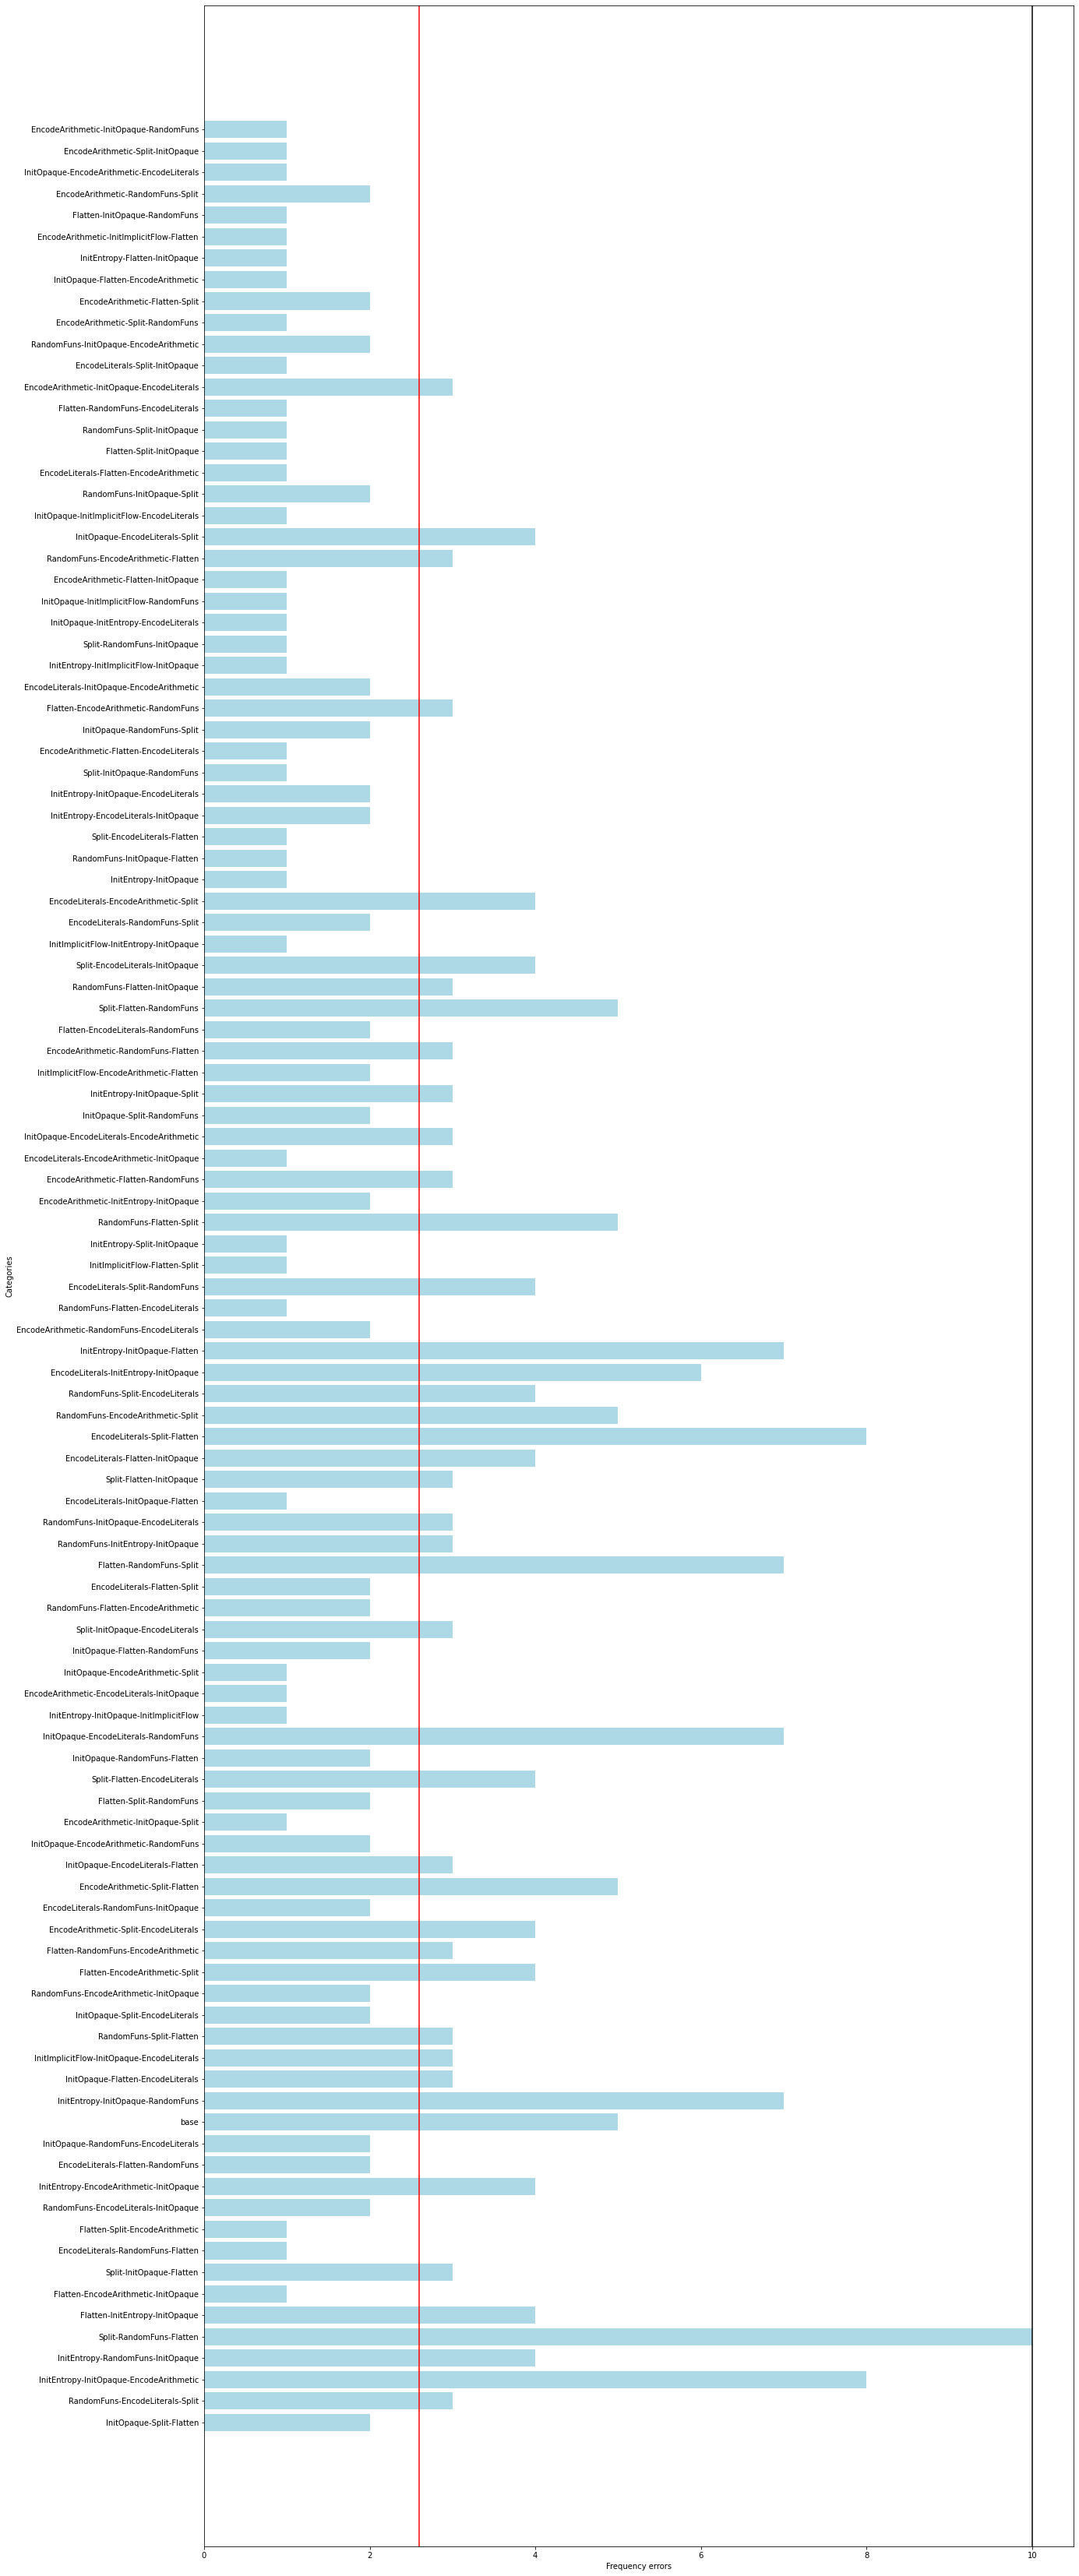


Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione


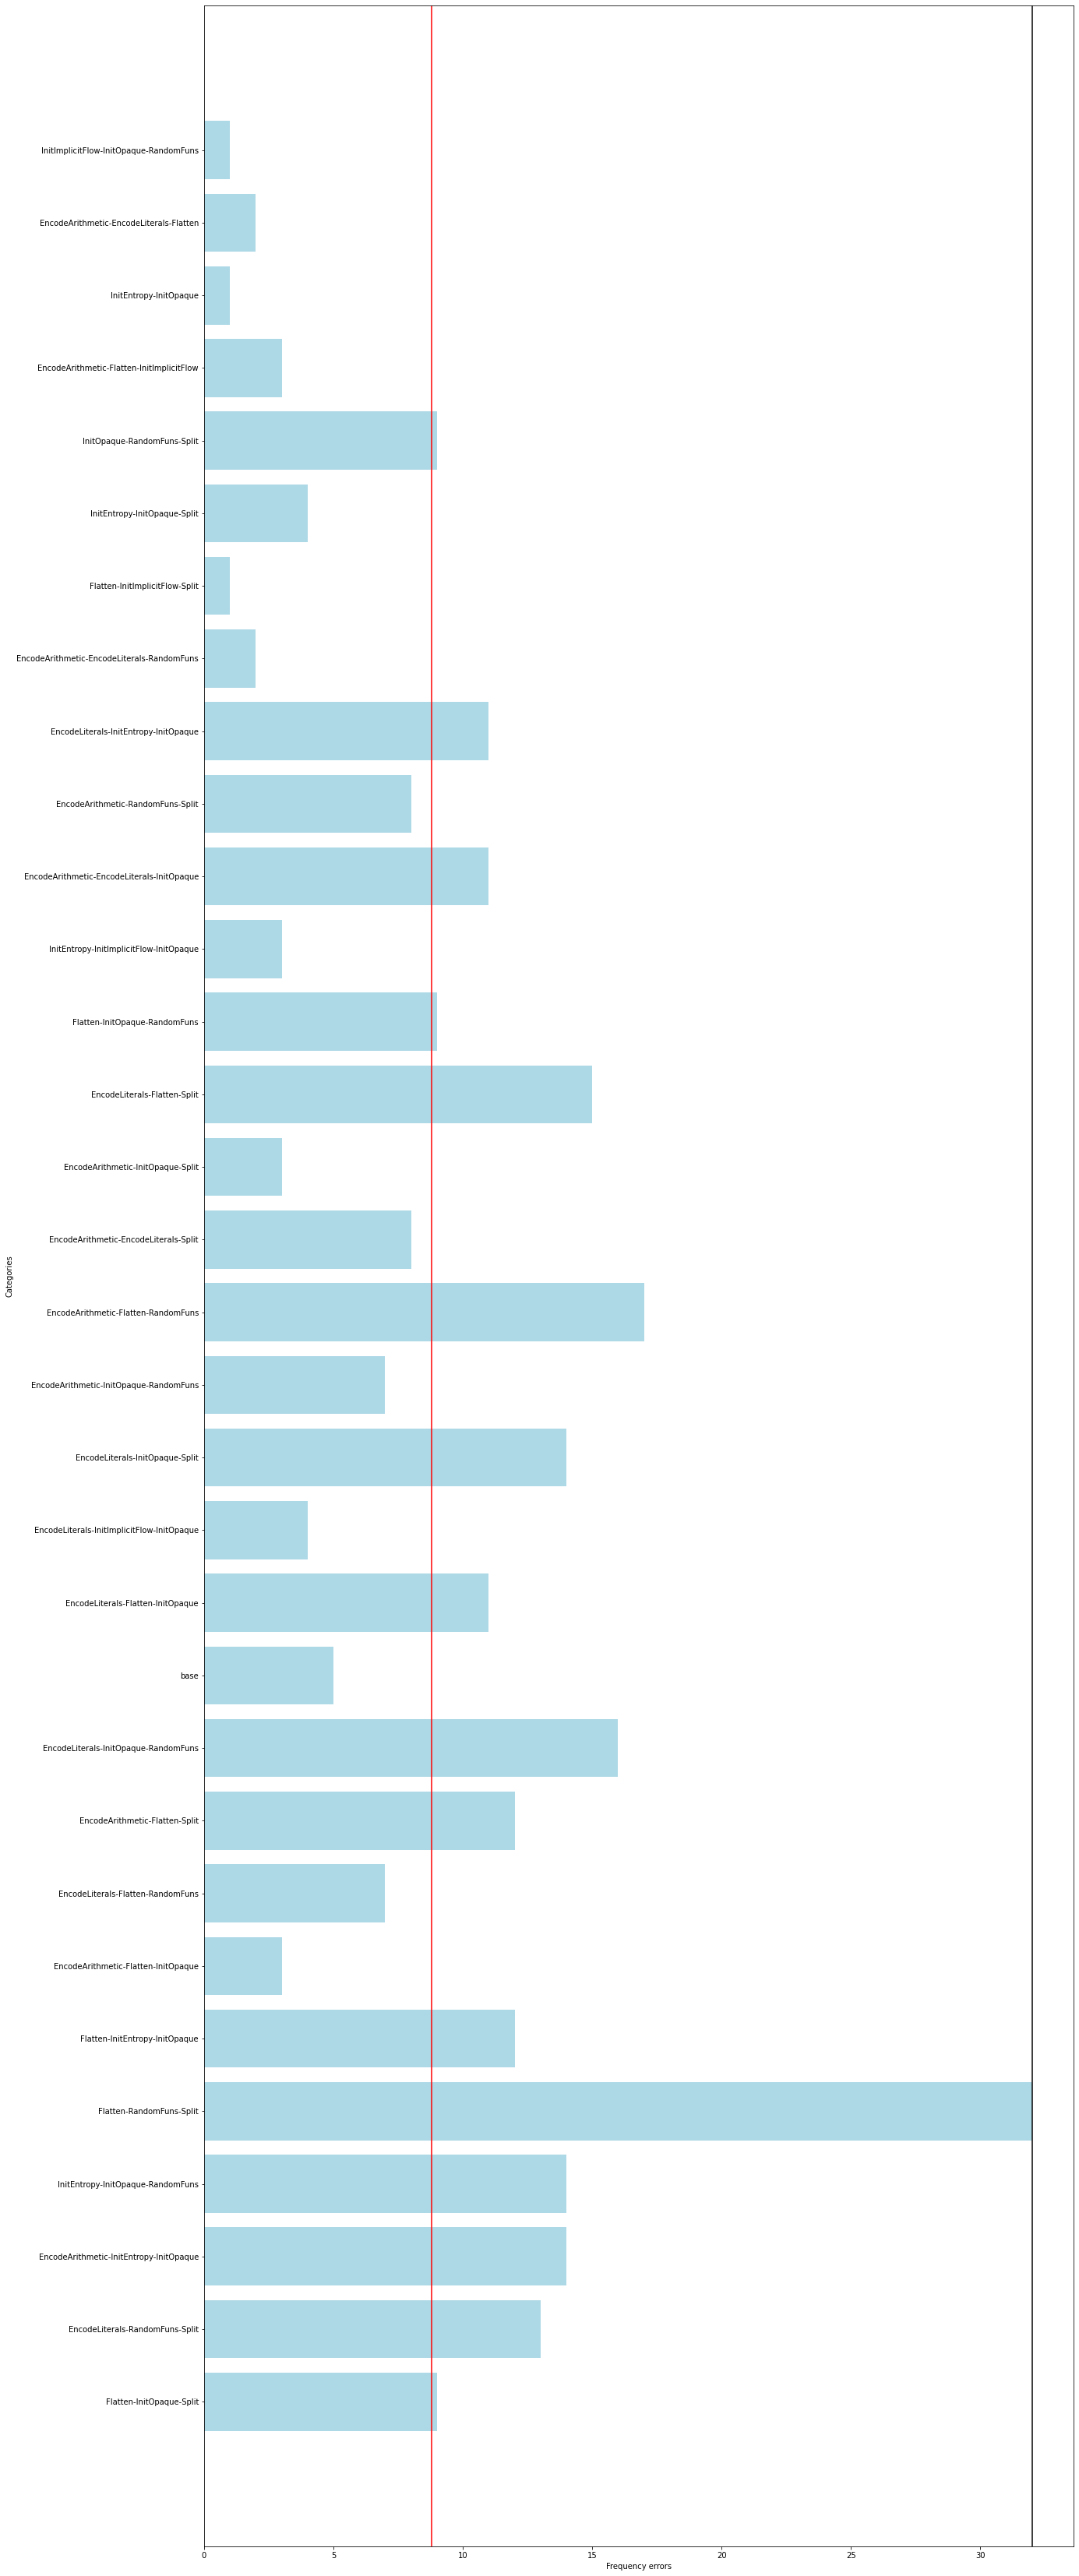


Grafo degli errori per classe


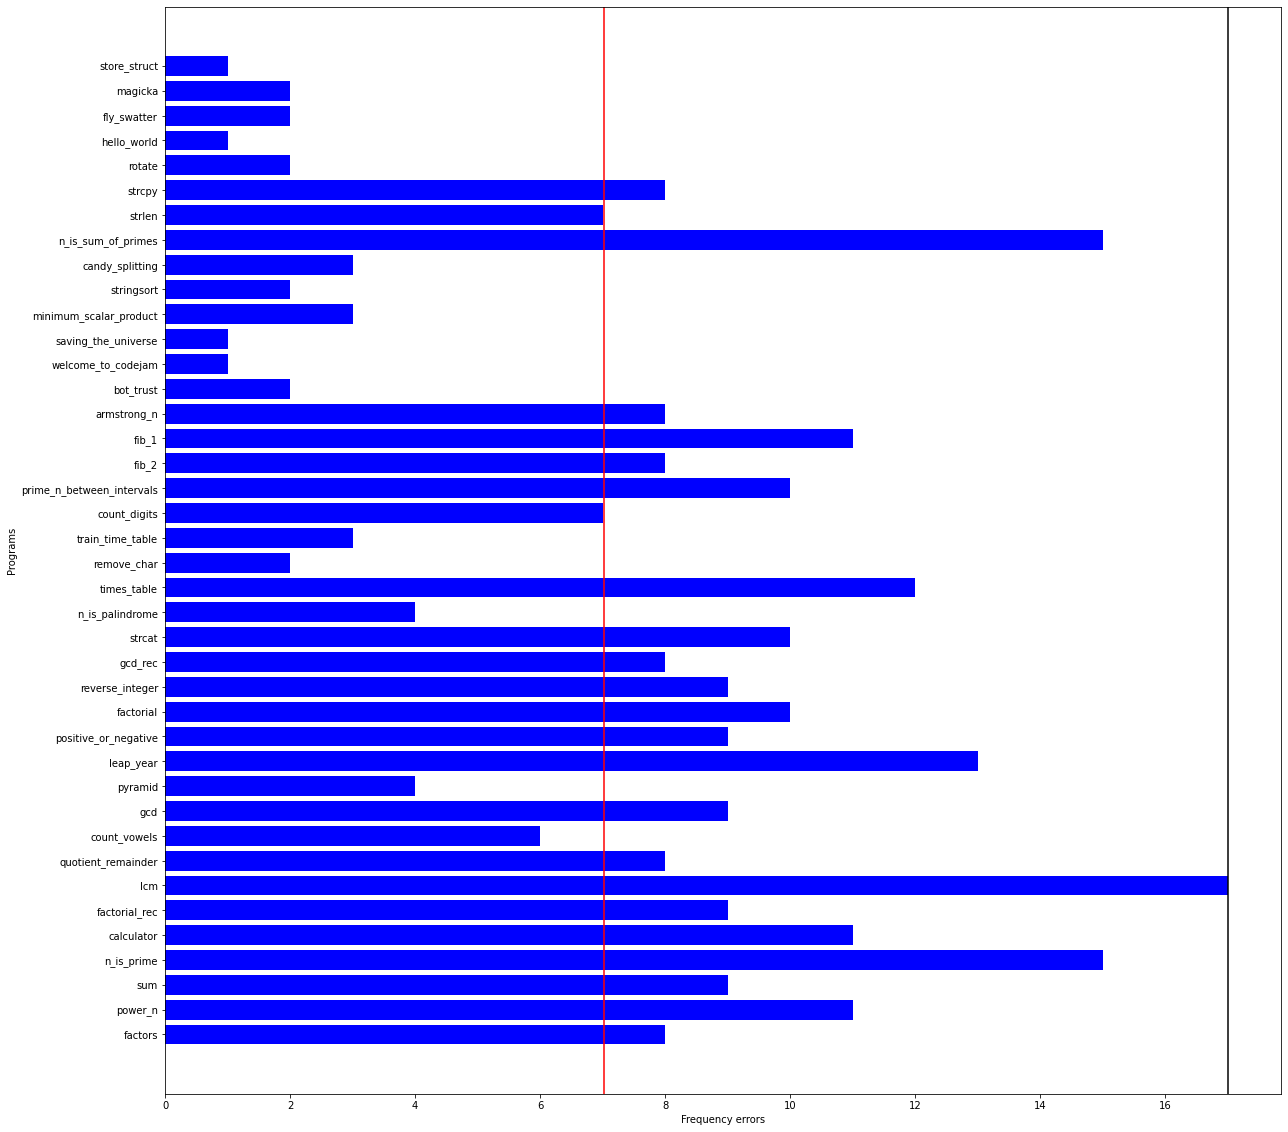


Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero


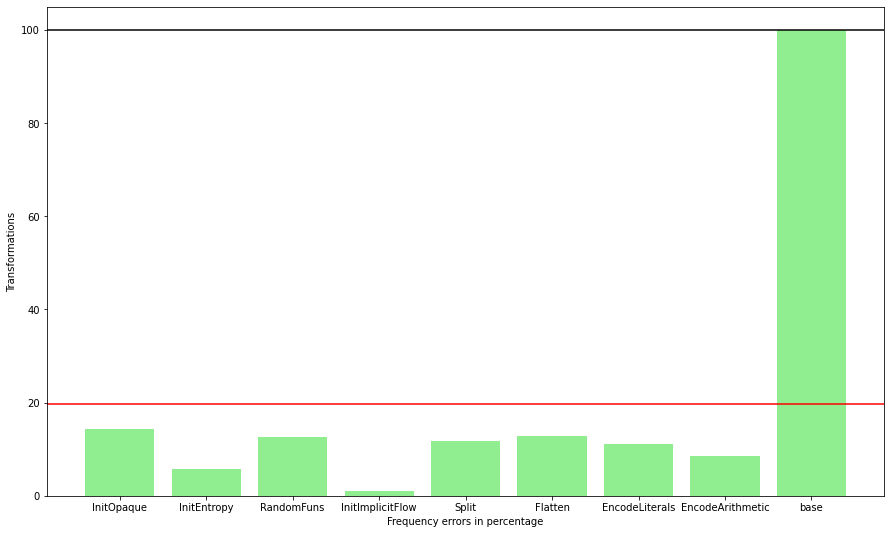

In [14]:
count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelLSTM, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
img_wrongObf_1 = my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue")
plt.show(img_wrongObf_1)
print()

print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
img_count_ord_wrObfs_1 = my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue")
plt.show(img_count_ord_wrObfs_1)
print()

print("Grafo degli errori per classe")
img_count_WrongClasses_1 = my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue")
plt.show(img_count_WrongClasses_1)
print()

print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
img_sing_wrObf_perc_1 = my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen")
plt.show(img_sing_wrObf_perc_1)

In [15]:
#Ordina e ritorna una lista
ordered_set_obfs = count_ordered_wr_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('Flatten-RandomFuns-Split', 32)
('EncodeArithmetic-Flatten-RandomFuns', 17)
('EncodeLiterals-InitOpaque-RandomFuns', 16)
('EncodeLiterals-Flatten-Split', 15)
('EncodeArithmetic-InitEntropy-InitOpaque', 14)
('InitEntropy-InitOpaque-RandomFuns', 14)
('EncodeLiterals-InitOpaque-Split', 14)
('EncodeLiterals-RandomFuns-Split', 13)
('Flatten-InitEntropy-InitOpaque', 12)
('EncodeArithmetic-Flatten-Split', 12)
('EncodeLiterals-Flatten-InitOpaque', 11)
('EncodeArithmetic-EncodeLiterals-InitOpaque', 11)
('EncodeLiterals-InitEntropy-InitOpaque', 11)
('Flatten-InitOpaque-Split', 9)
('Flatten-InitOpaque-RandomFuns', 9)
('InitOpaque-RandomFuns-Split', 9)
('EncodeArithmetic-EncodeLiterals-Split', 8)
('EncodeArithmetic-RandomFuns-Split', 8)
('EncodeLiterals-Flatten-RandomFuns', 7)
('EncodeArithmetic-InitOpaque-RandomFuns', 7)
('base', 5)
('EncodeLiterals-InitImplicitFlow-InitOpaque', 4)
('InitEntropy-InitOpaque-Split', 4)
('EncodeArithmetic-Flatten-InitOpaque', 3)
('EncodeArithmetic-InitOpaque-Split'

In [16]:
ordered_tot = my_lib.order_dict_of_dict(percent_wr_classeXobf_tot)
print("Classi - percentuale su tutto test set")
my_lib.stampa_percent_classeXobf(ordered_tot)

Classi - percentuale su tutto test set
factors := InitOpaque: 28.57%; Flatten: 20.0%; Split: 18.52%; EncodeLiterals: 15.79%; RandomFuns: 14.29%; InitEntropy: 10.0%; EncodeArithmetic: 5.56%; 
power_n := RandomFuns: 27.59%; Flatten: 25.93%; Split: 23.81%; InitOpaque: 22.73%; EncodeArithmetic: 20.83%; InitEntropy: 7.69%; EncodeLiterals: 7.14%; 
sum := Flatten: 30.0%; InitOpaque: 21.74%; RandomFuns: 17.39%; EncodeLiterals: 16.67%; Split: 13.79%; InitEntropy: 12.5%; EncodeArithmetic: 4.35%; 
n_is_prime := InitOpaque: 35.71%; EncodeArithmetic: 34.48%; Flatten: 29.17%; EncodeLiterals: 28.0%; Split: 19.05%; RandomFuns: 14.81%; InitEntropy: 10.0%; 
calculator := InitOpaque: 31.58%; Split: 27.78%; Flatten: 25.93%; EncodeLiterals: 24.0%; EncodeArithmetic: 17.39%; RandomFuns: 16.0%; InitEntropy: 4.35%; 
factorial_rec := RandomFuns: 35.0%; Flatten: 28.57%; Split: 27.78%; EncodeLiterals: 25.0%; InitOpaque: 17.65%; InitEntropy: 6.25%; 
lcm := InitOpaque: 42.31%; Split: 37.04%; RandomFuns: 35.48%; Fla

#Parametri modello 2 64x128

In [43]:
database_scelto = '18k' #or '14k' or '9k'

dim1 = 128
dim2 = 64
batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = dim1
n_features = dim2

n_epochs = 100
patience = 10

In [40]:
del sets_and_labels, numpy_arrays, label_encoder, n_classes
del train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded
del validation_obf
del sub_db

In [44]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

18800
START IMAGE INPUT
END IMAGE INPUT


In [45]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

##Modello 2

In [46]:
modelLSTM2, hist2, time_callback2 = my_lib.modelLSTM(num_units1, num_units2, time_steps, n_features, batch_size, n_classes, patience, sub_db, n_epochs)

##Risultati modello 2

In [47]:
number_of_epochs_it_ran = len(hist2.history['loss'])

time_per_epoch = time_callback2.times
total_time = sum(time_per_epoch)

test_accuracy = modelLSTM2.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

3008/3008 [==============================] - 1s 367us/sample - loss: 0.4161 - acc: 0.9199
Total epochs 100
345.49552035331726 s


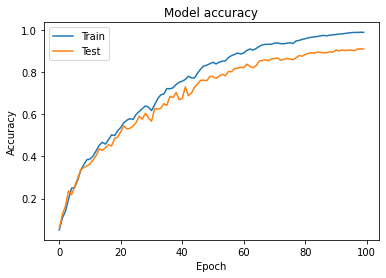

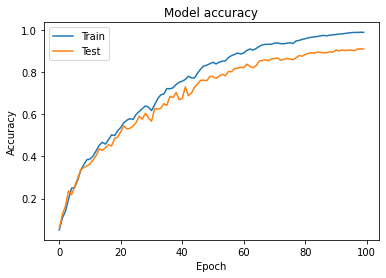

In [48]:
modelAcc2 = my_lib.plot_model_acc(hist2)
modelLoss2 = my_lib.plot_model_acc(hist2)

plt.show(modelAcc2)
plt.show(modelLoss2)

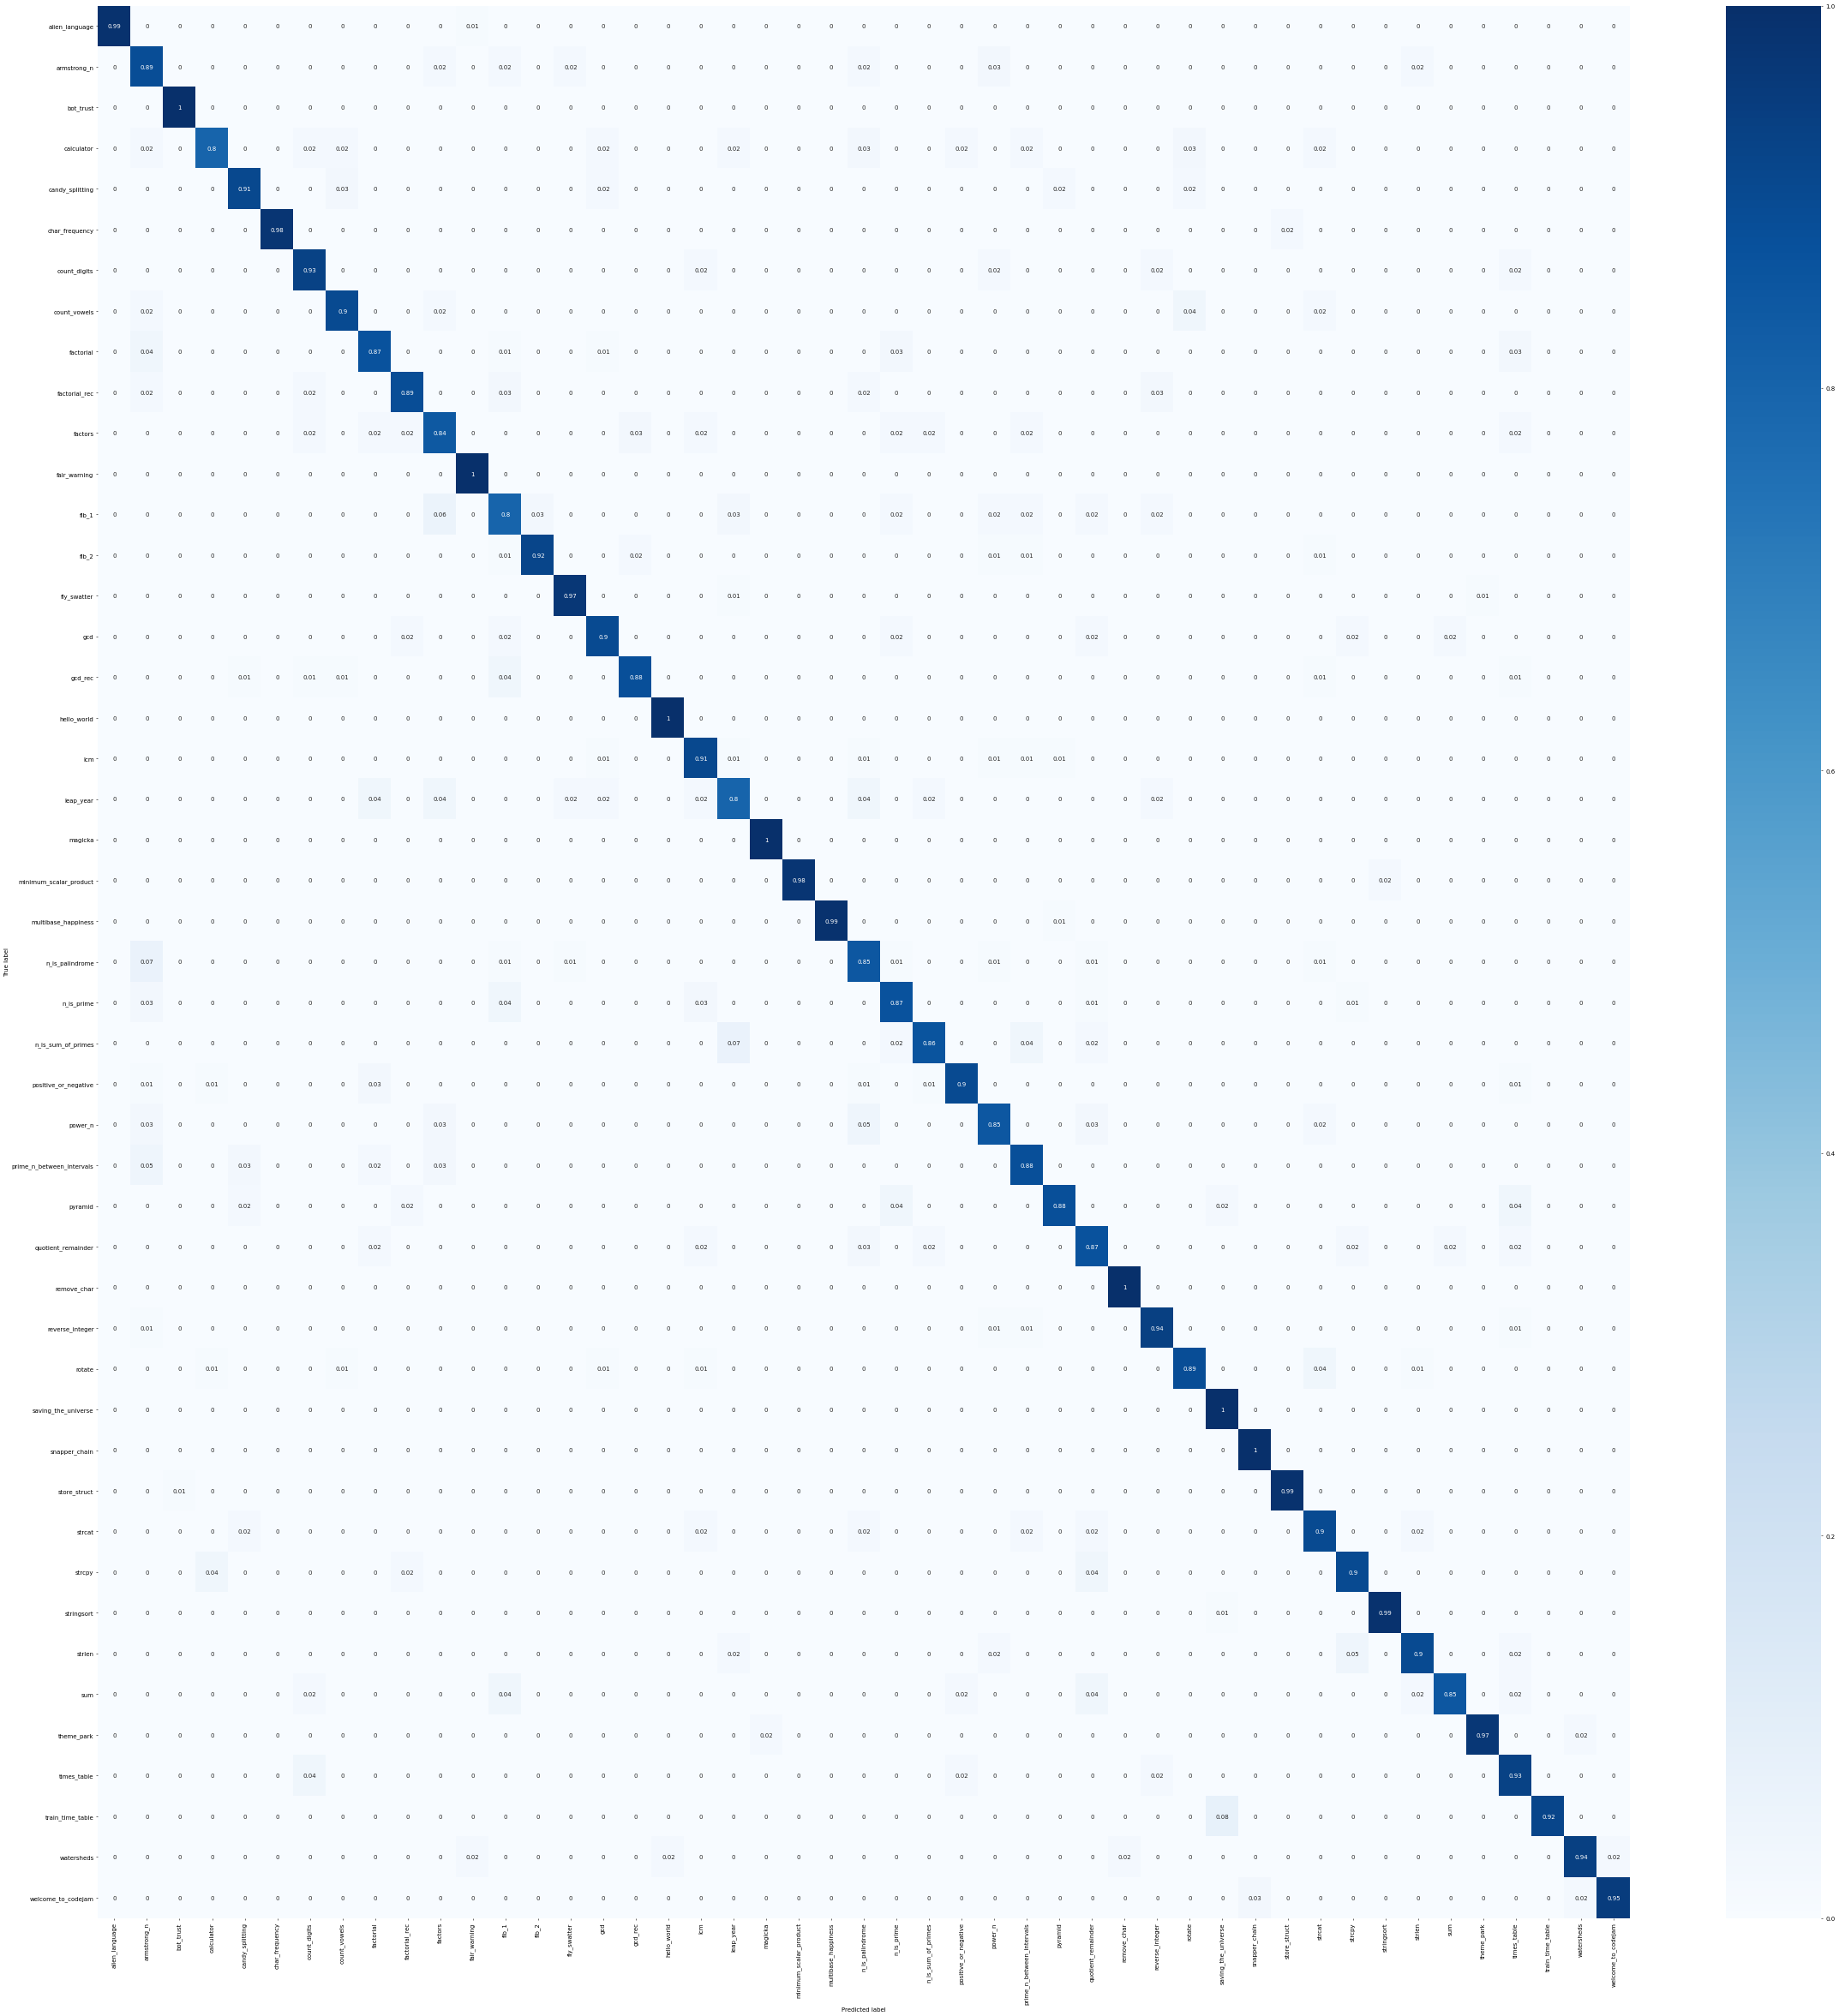

In [49]:
confMat2 = my_lib.plot_conf_matrix(modelLSTM2, validation_images, validation_labels_encoded, label_encoder)
plt.show(confMat2)

Grafo degli errori focalizzato sul singolo set di offuscamento


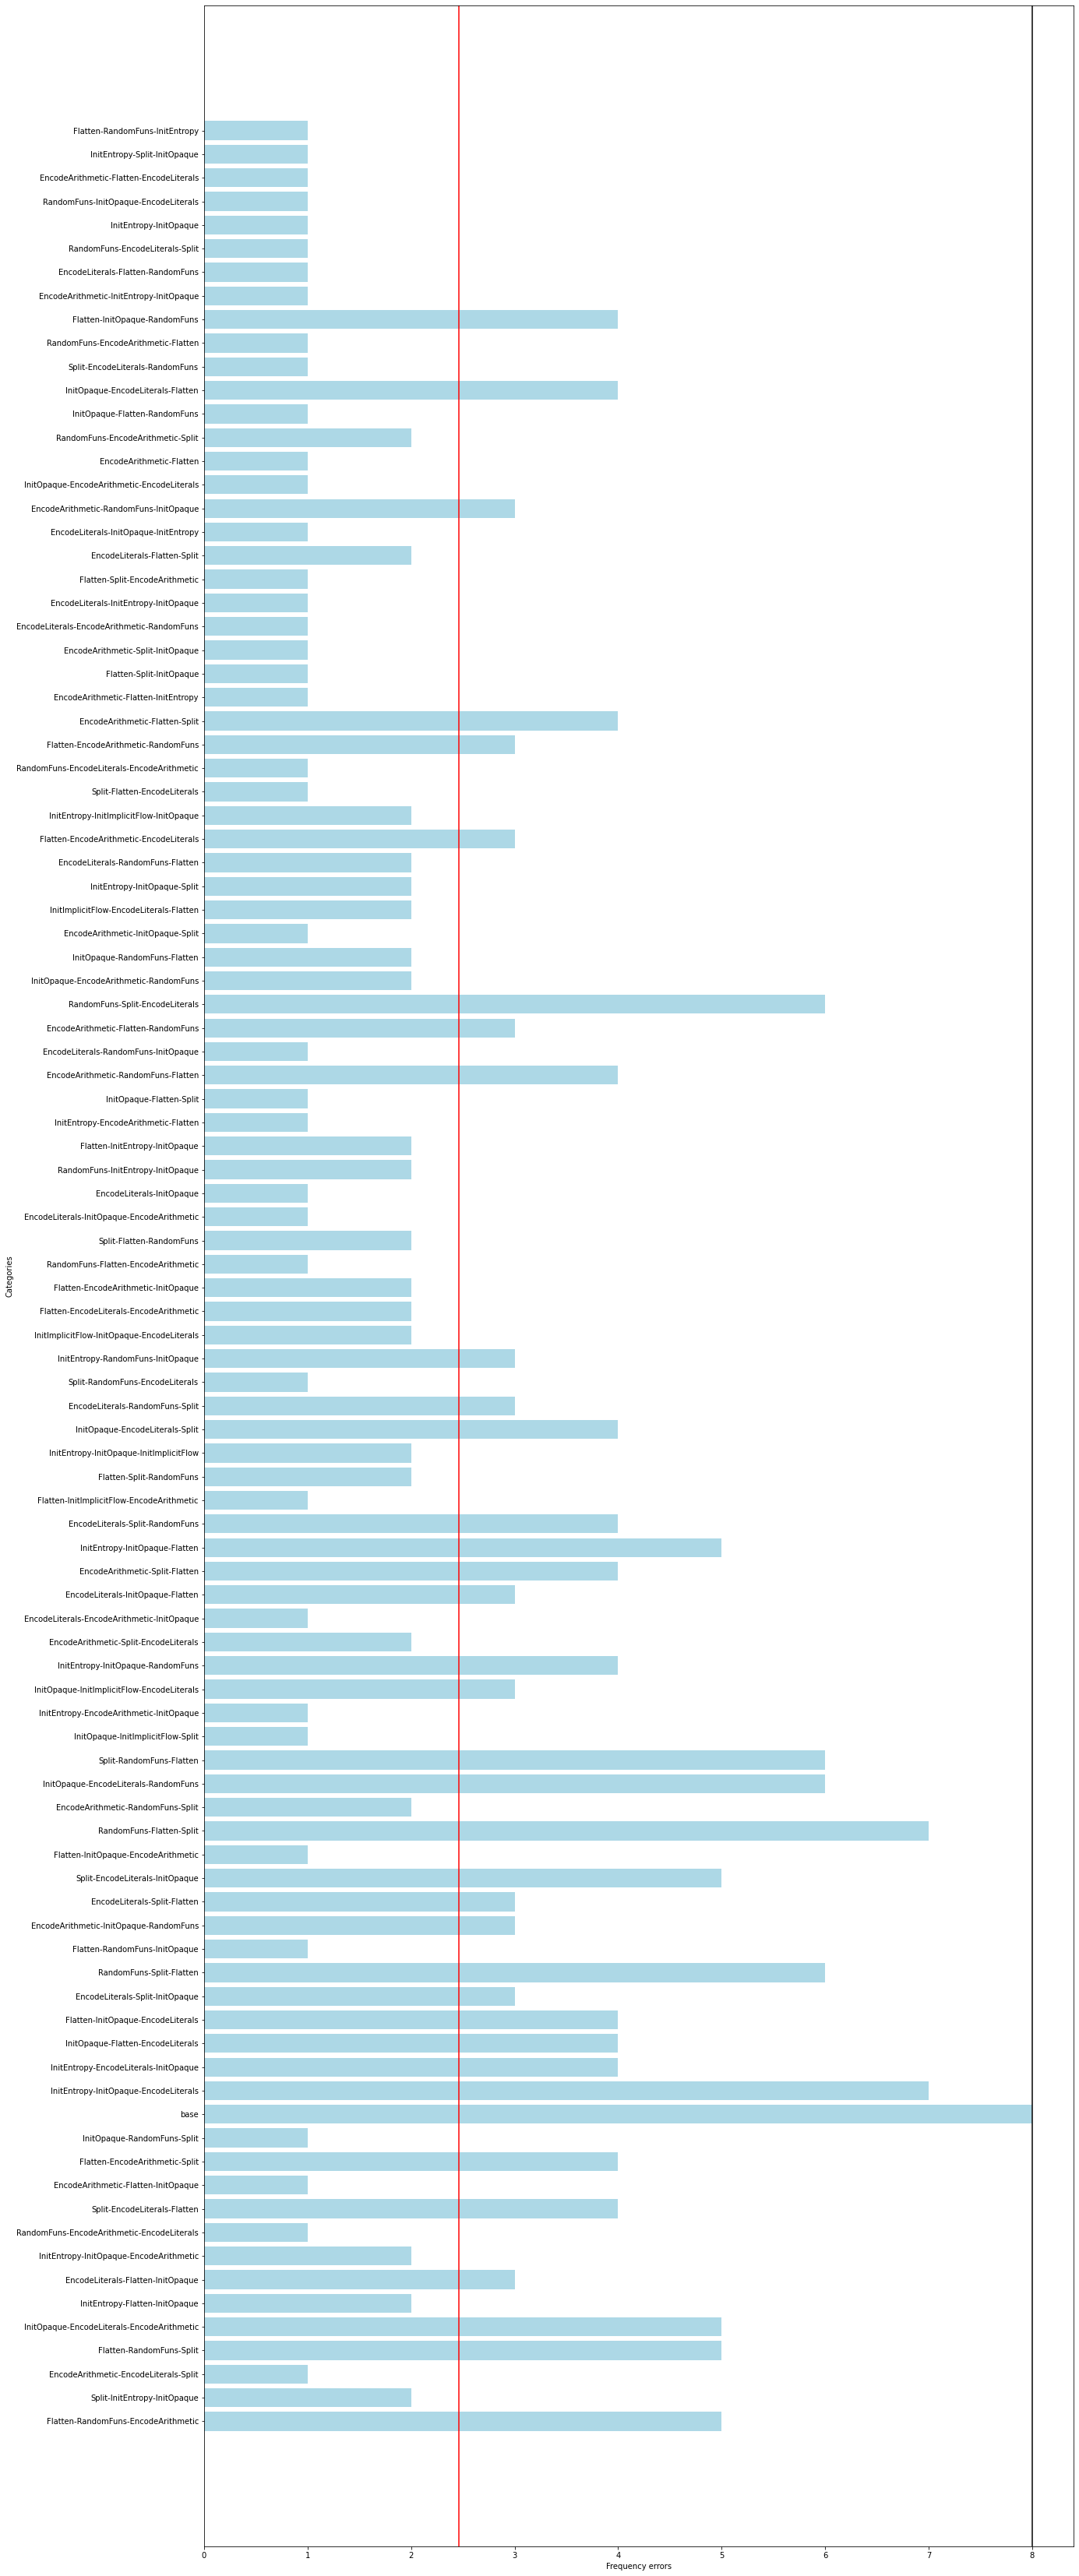


Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione


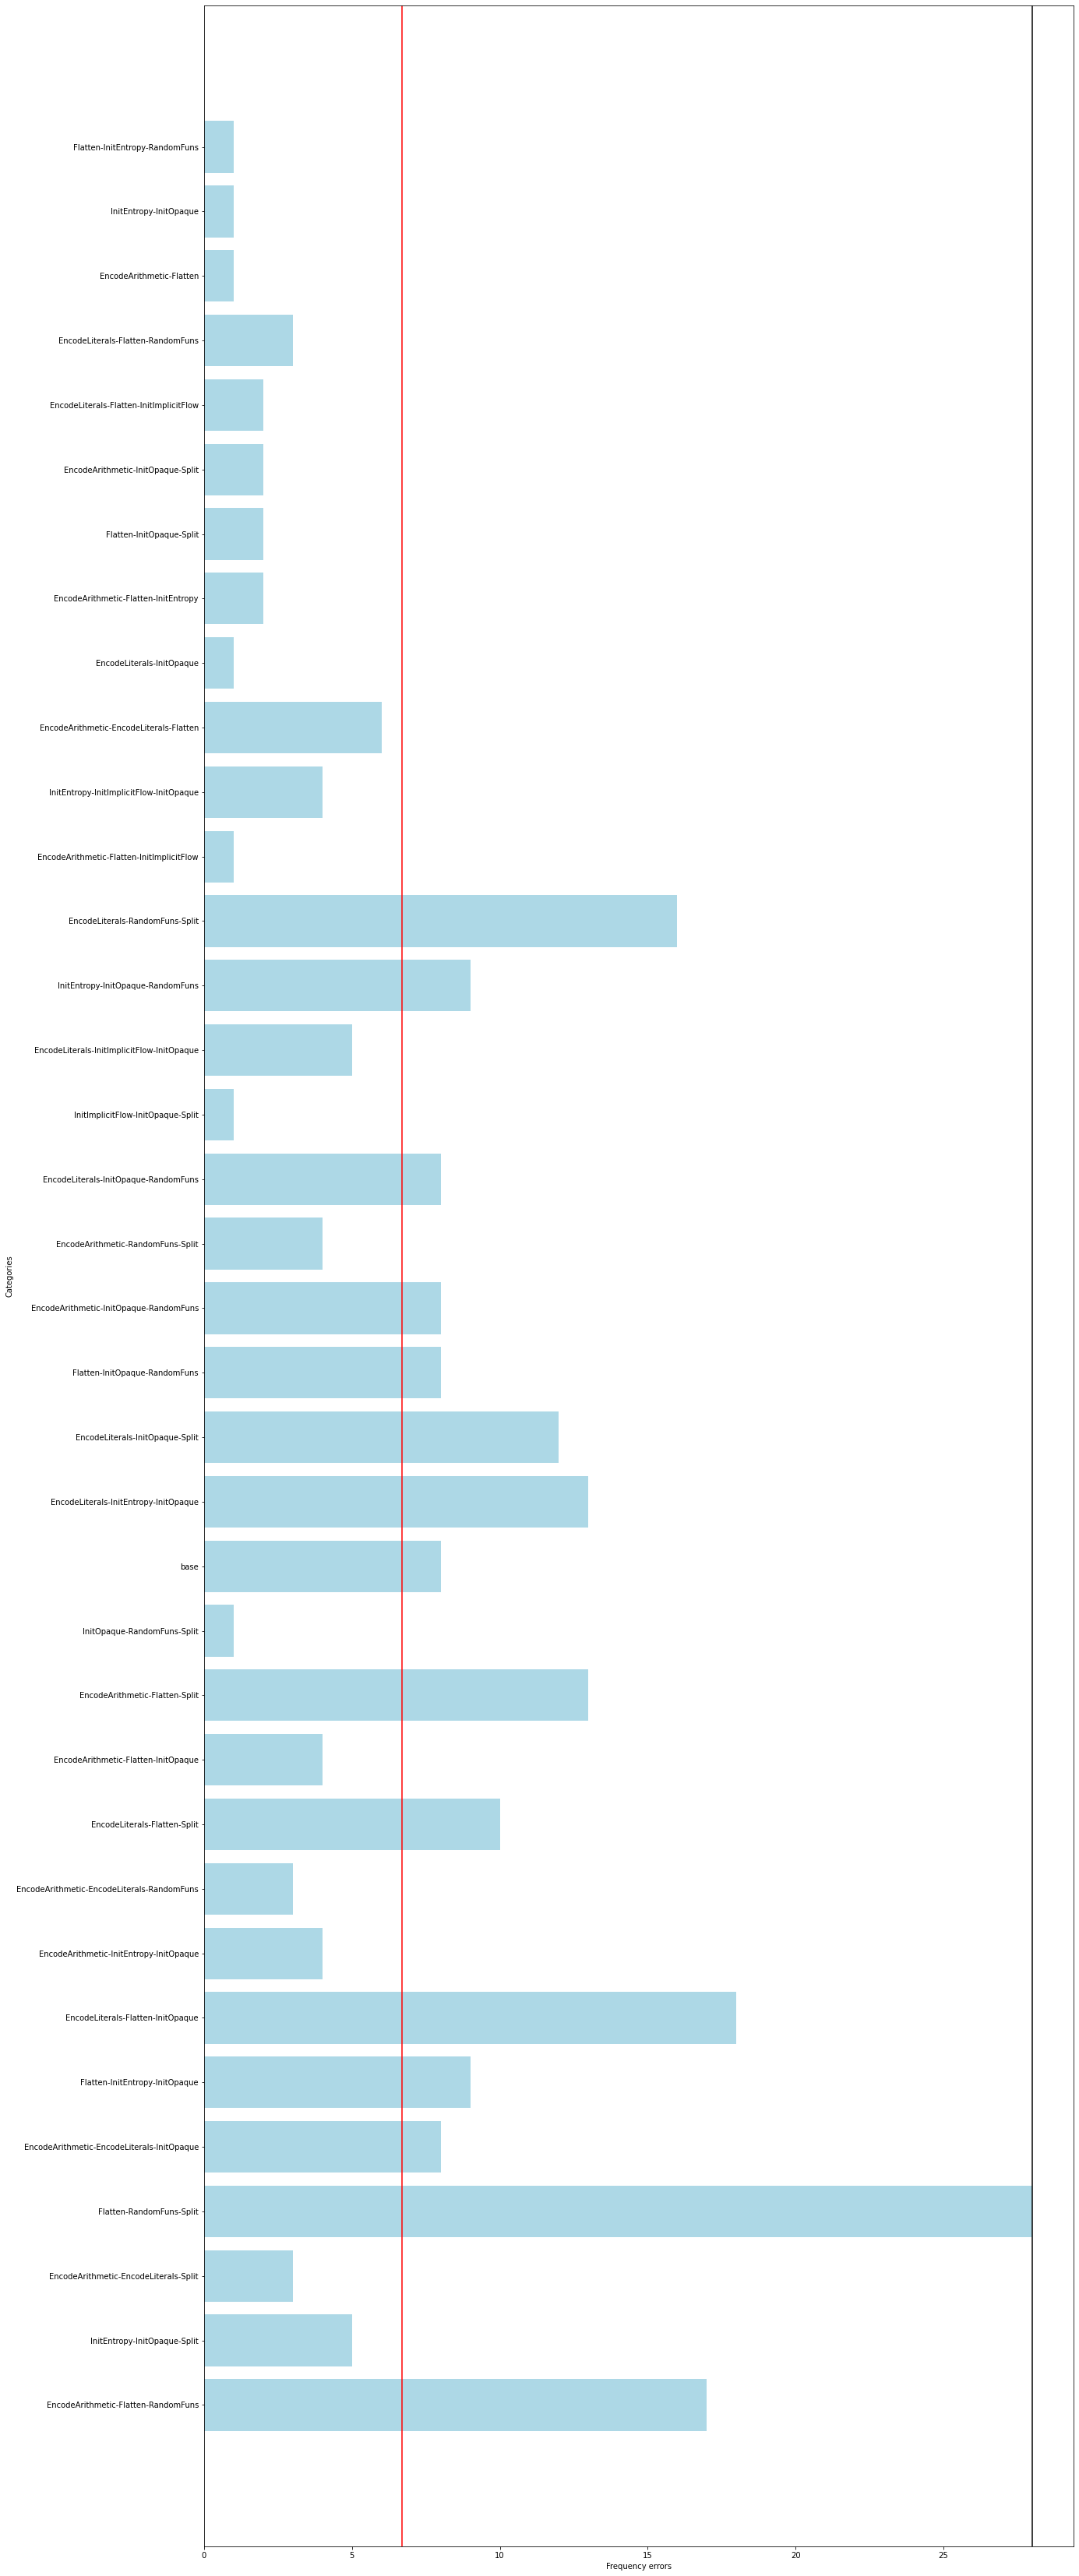


Grafo degli errori per classe


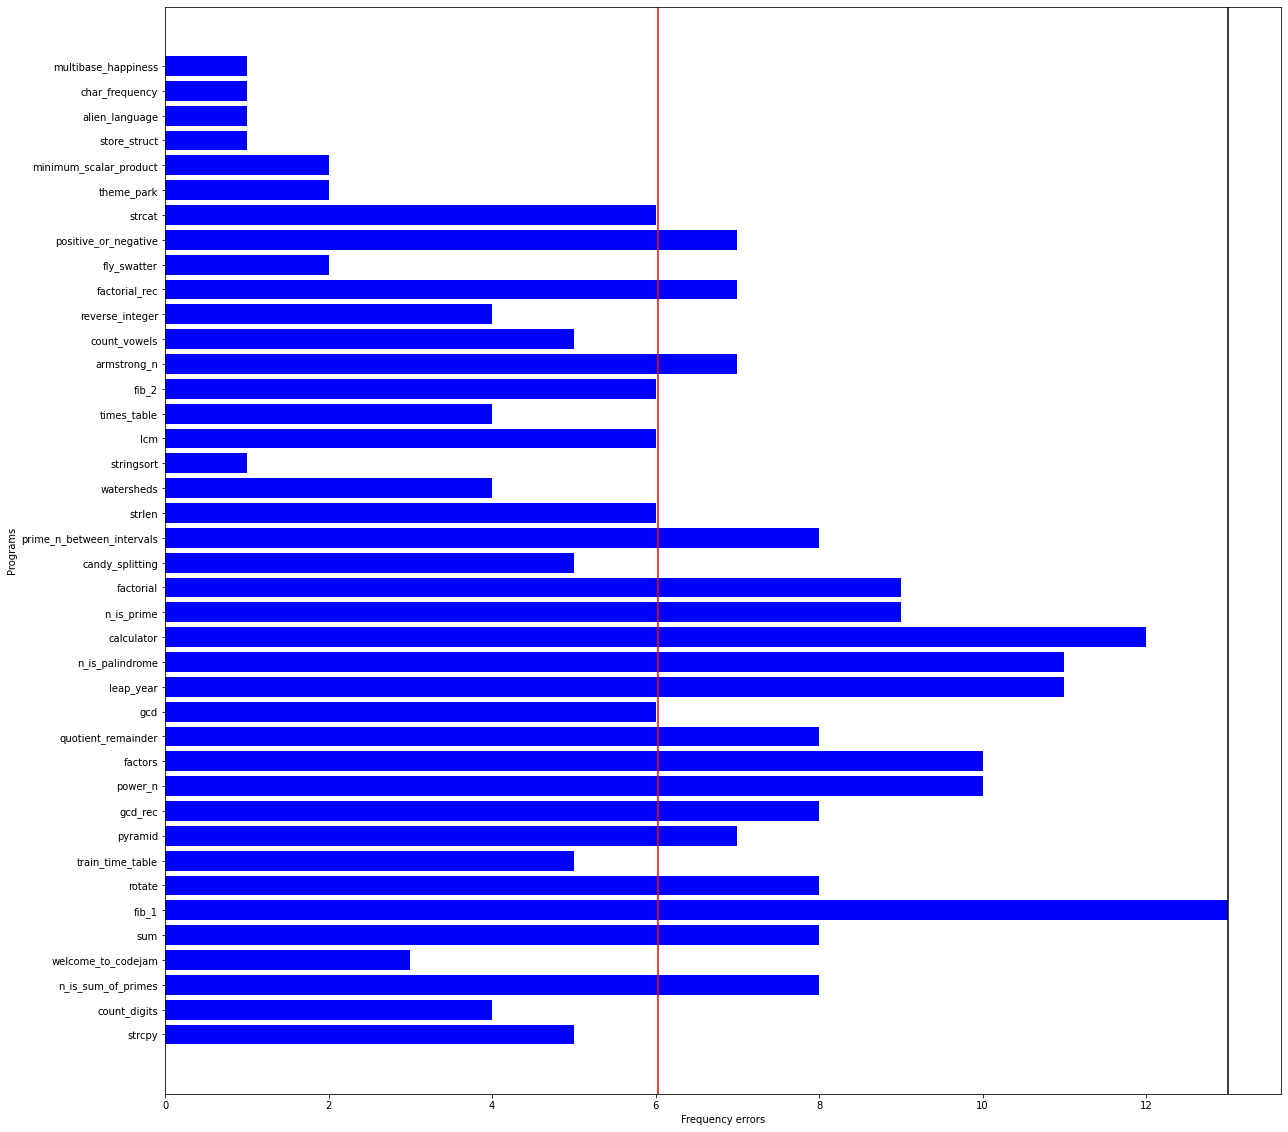


Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero


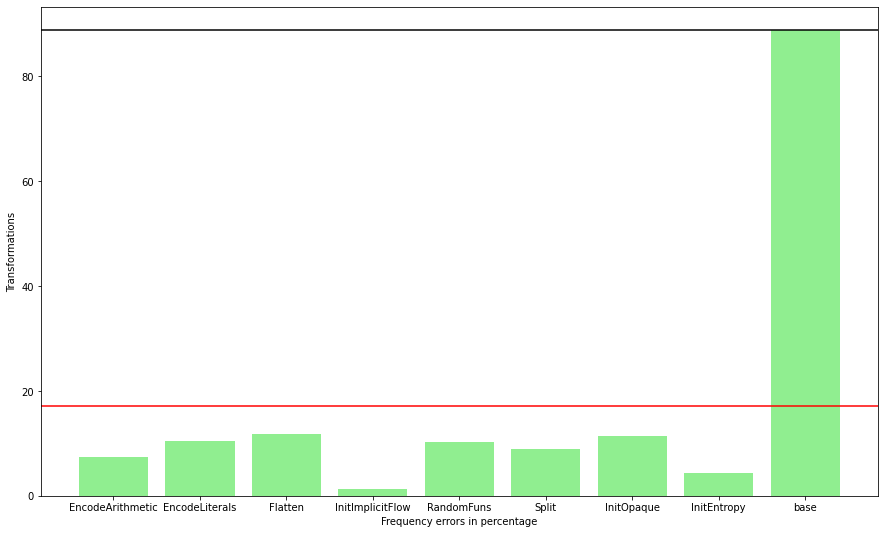

In [50]:
count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelLSTM2, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
img_wrongObf_2 = my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue")
plt.show(img_wrongObf_2)
print()

print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
img_count_ord_wrObfs_2 = my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue")
plt.show(img_count_ord_wrObfs_2)
print()

print("Grafo degli errori per classe")
img_count_WrongClasses_2 = my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue")
plt.show(img_count_WrongClasses_2)
print()

print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
img_sing_wrObf_perc_2 = my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen")
plt.show(img_sing_wrObf_perc_2)

In [51]:
#Ordina e ritorna una lista
ordered_set_obfs = count_ordered_wr_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('Flatten-RandomFuns-Split', 28)
('EncodeLiterals-Flatten-InitOpaque', 18)
('EncodeArithmetic-Flatten-RandomFuns', 17)
('EncodeLiterals-RandomFuns-Split', 16)
('EncodeArithmetic-Flatten-Split', 13)
('EncodeLiterals-InitEntropy-InitOpaque', 13)
('EncodeLiterals-InitOpaque-Split', 12)
('EncodeLiterals-Flatten-Split', 10)
('Flatten-InitEntropy-InitOpaque', 9)
('InitEntropy-InitOpaque-RandomFuns', 9)
('EncodeArithmetic-EncodeLiterals-InitOpaque', 8)
('base', 8)
('Flatten-InitOpaque-RandomFuns', 8)
('EncodeArithmetic-InitOpaque-RandomFuns', 8)
('EncodeLiterals-InitOpaque-RandomFuns', 8)
('EncodeArithmetic-EncodeLiterals-Flatten', 6)
('InitEntropy-InitOpaque-Split', 5)
('EncodeLiterals-InitImplicitFlow-InitOpaque', 5)
('EncodeArithmetic-InitEntropy-InitOpaque', 4)
('EncodeArithmetic-Flatten-InitOpaque', 4)
('EncodeArithmetic-RandomFuns-Split', 4)
('InitEntropy-InitImplicitFlow-InitOpaque', 4)
('EncodeArithmetic-EncodeLiterals-Split', 3)
('EncodeArithmetic-EncodeLiterals-RandomFuns', 3)
('Enc

In [52]:
ordered_tot = my_lib.order_dict_of_dict(percent_wr_classeXobf_tot)
print("Classi - percentuale su tutto test set")
my_lib.stampa_percent_classeXobf(ordered_tot)

Classi - percentuale su tutto test set
strcpy := RandomFuns: 18.18%; EncodeArithmetic: 17.65%; Flatten: 14.29%; InitOpaque: 13.04%; Split: 10.53%; EncodeLiterals: 7.69%; 
count_digits := InitOpaque: 21.05%; EncodeLiterals: 10.0%; Split: 8.33%; InitEntropy: 7.41%; Flatten: 5.56%; 
n_is_sum_of_primes := Split: 25.0%; Flatten: 23.53%; RandomFuns: 22.22%; EncodeLiterals: 19.05%; InitOpaque: 18.18%; InitEntropy: 8.33%; InitImplicitFlow: 5.88%; EncodeArithmetic: 5.56%; 
welcome_to_codejam := Flatten: 12.5%; InitOpaque: 9.52%; EncodeLiterals: 7.41%; Split: 5.56%; RandomFuns: 5.0%; 
sum := RandomFuns: 31.58%; InitOpaque: 25.0%; EncodeArithmetic: 25.0%; Flatten: 20.0%; EncodeLiterals: 11.76%; Split: 11.11%; 
fib_1 := base: 100.0%; EncodeLiterals: 31.58%; InitOpaque: 25.81%; Flatten: 21.74%; Split: 21.74%; InitEntropy: 20.83%; RandomFuns: 13.33%; EncodeArithmetic: 11.54%; InitImplicitFlow: 4.55%; 
rotate := InitOpaque: 22.22%; Flatten: 20.69%; EncodeLiterals: 18.18%; RandomFuns: 15.79%; Split: 7

#Parametri modello 3 64x64

In [28]:
database_scelto = '18k' #or '14k' or '9k'

dim1 = 64
dim2 = 64
batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = dim1
n_features = dim2

n_epochs = 100
patience = 10

In [29]:
del sets_and_labels, numpy_arrays, label_encoder, n_classes
del train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded
del validation_obf
del sub_db

In [30]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

18800
START IMAGE INPUT
END IMAGE INPUT


In [31]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

##Modello 3

In [32]:
modelLSTM3, hist3, time_callback3 = my_lib.modelLSTM(num_units1, num_units2, time_steps, n_features, batch_size, n_classes, patience, sub_db, n_epochs)

##Risultati modello 3

In [33]:
number_of_epochs_it_ran = len(hist3.history['loss'])

time_per_epoch = time_callback3.times
total_time = sum(time_per_epoch)

test_accuracy = modelLSTM3.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

3008/3008 [==============================] - 2s 793us/sample - loss: 0.7127 - acc: 0.8318
Total epochs 88
154.92184019088745 s


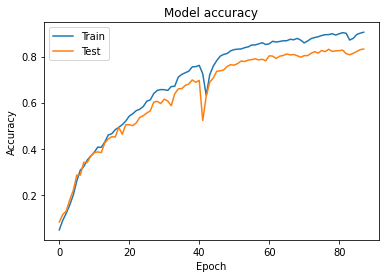

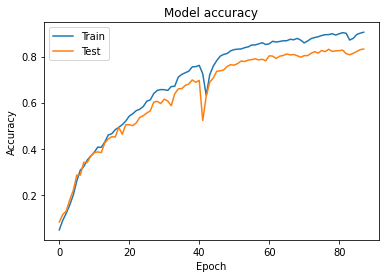

In [34]:
modelAcc3 = my_lib.plot_model_acc(hist3)
modelLoss3 = my_lib.plot_model_acc(hist3)

plt.show(modelAcc3)
plt.show(modelLoss3)

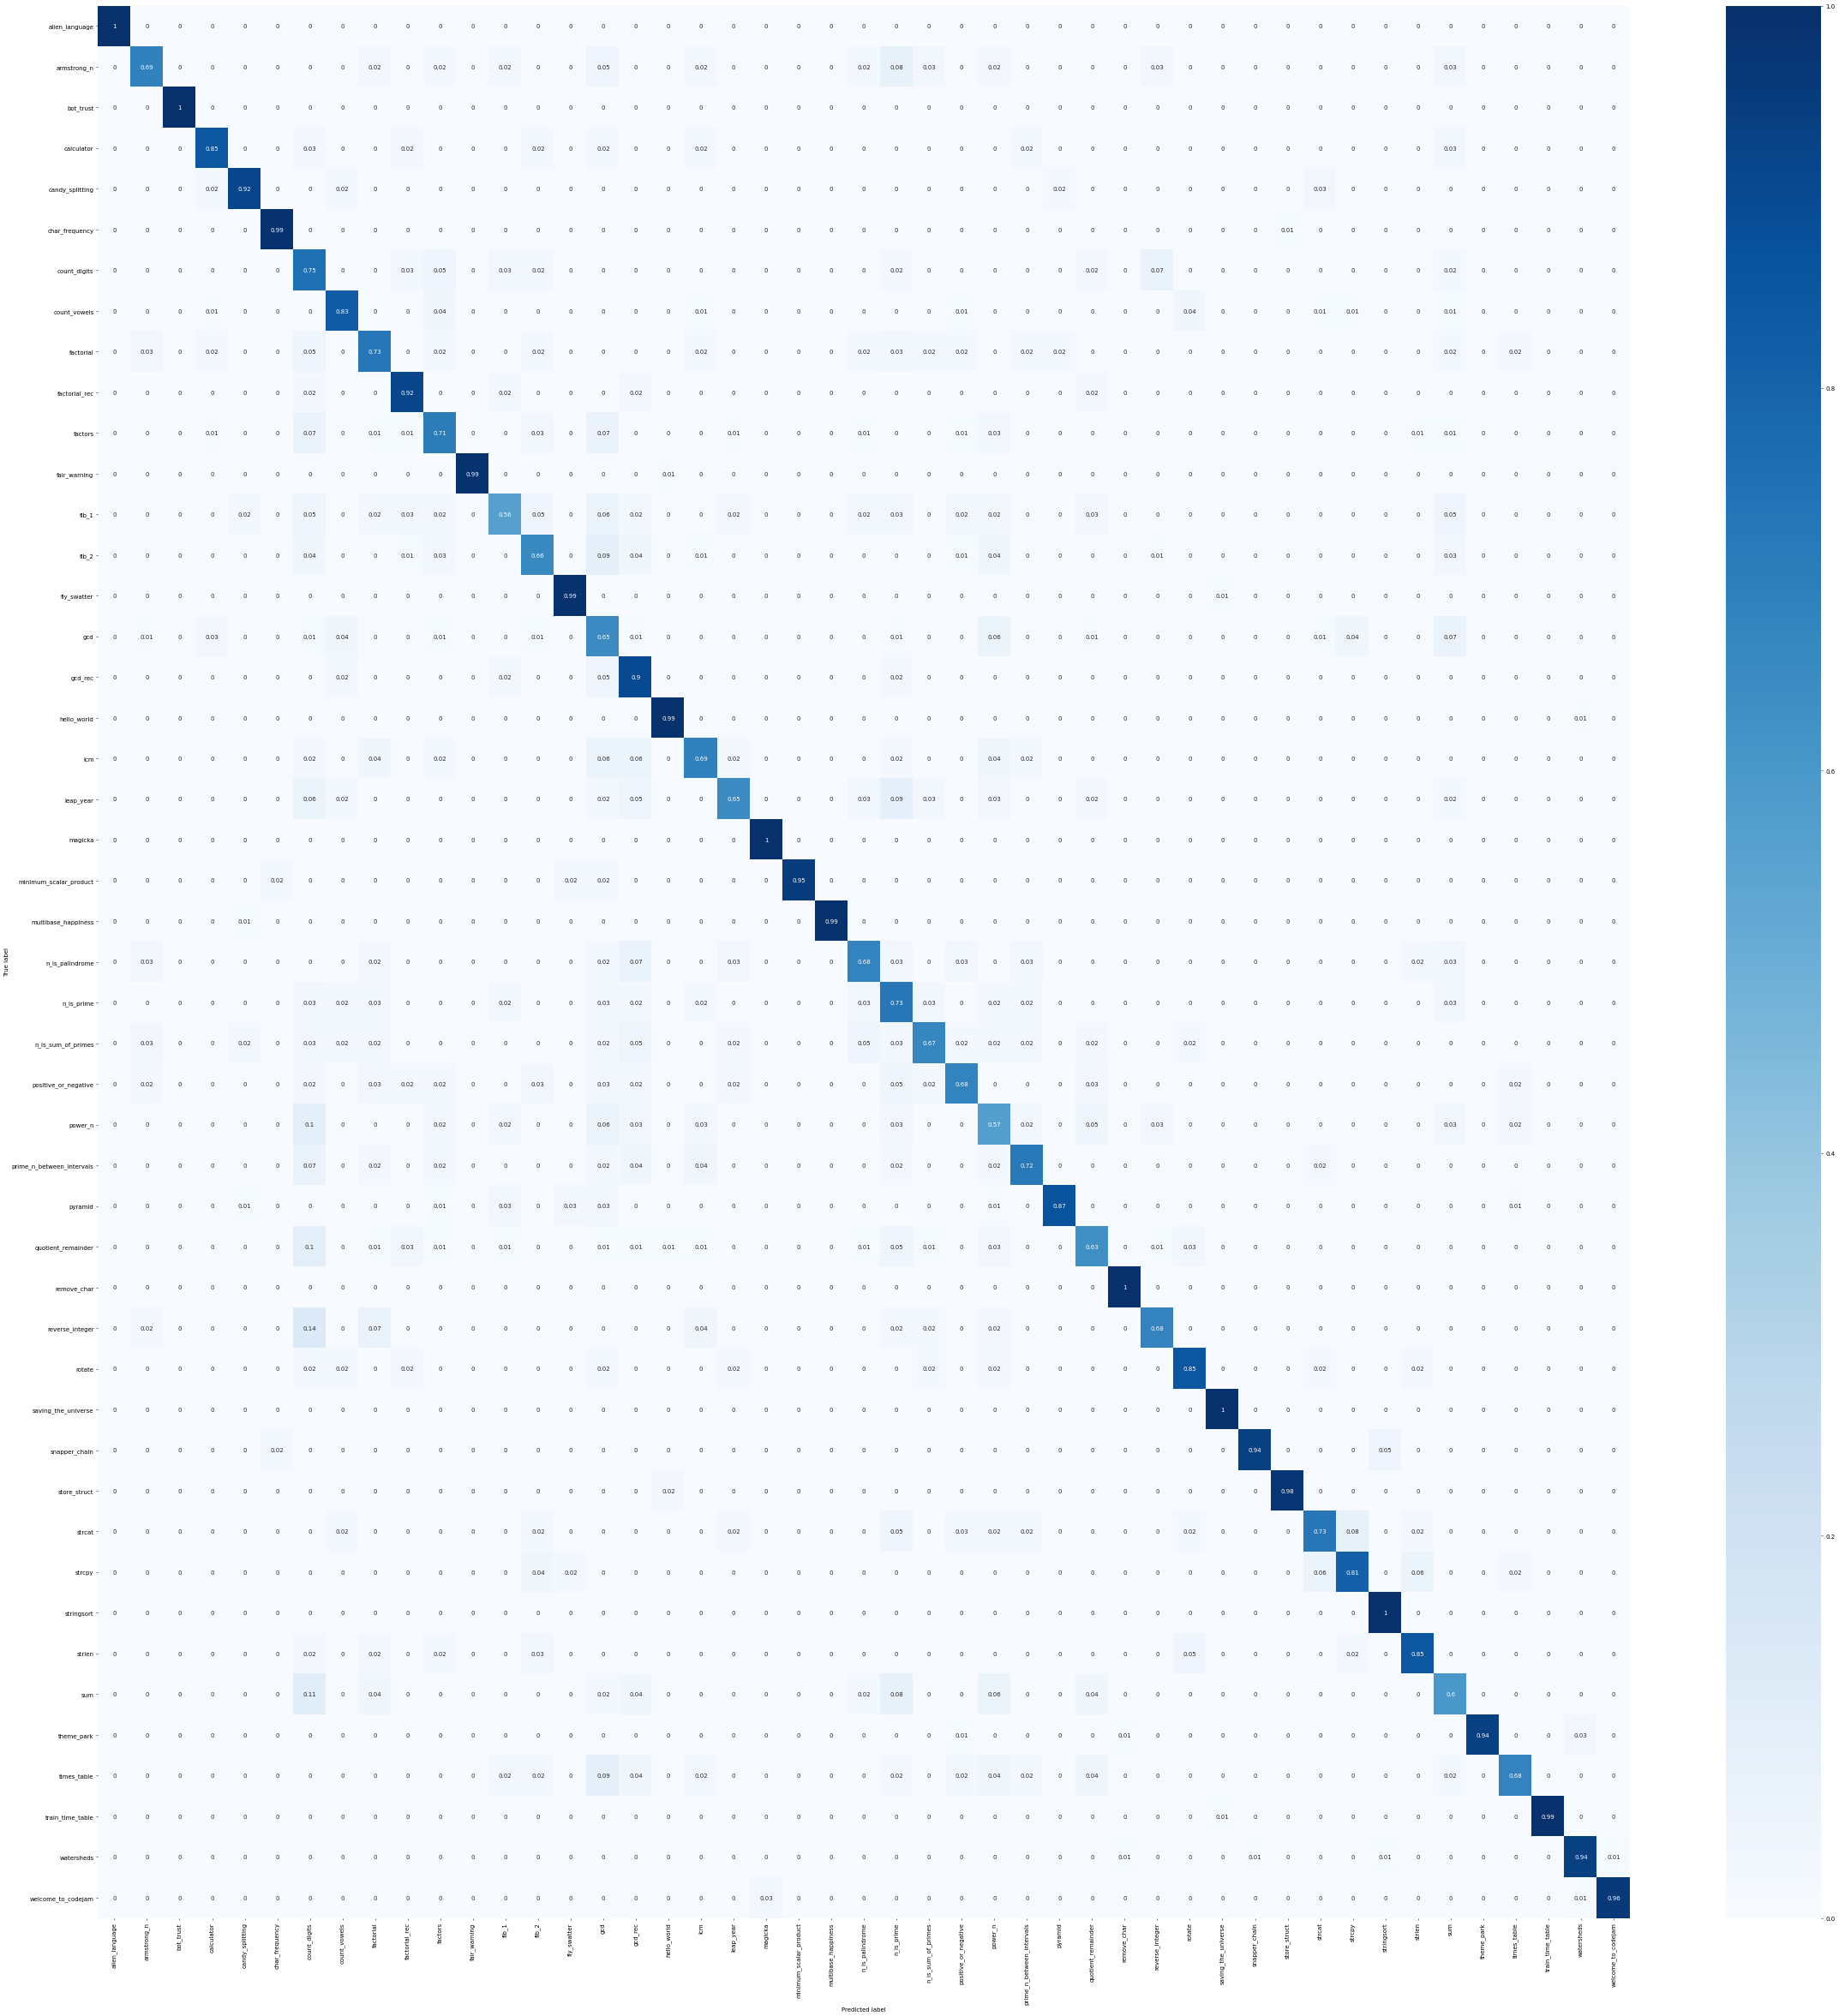

In [35]:
confMat3 = my_lib.plot_conf_matrix(modelLSTM3, validation_images, validation_labels_encoded, label_encoder)
plt.show(confMat3)

Grafo degli errori focalizzato sul singolo set di offuscamento


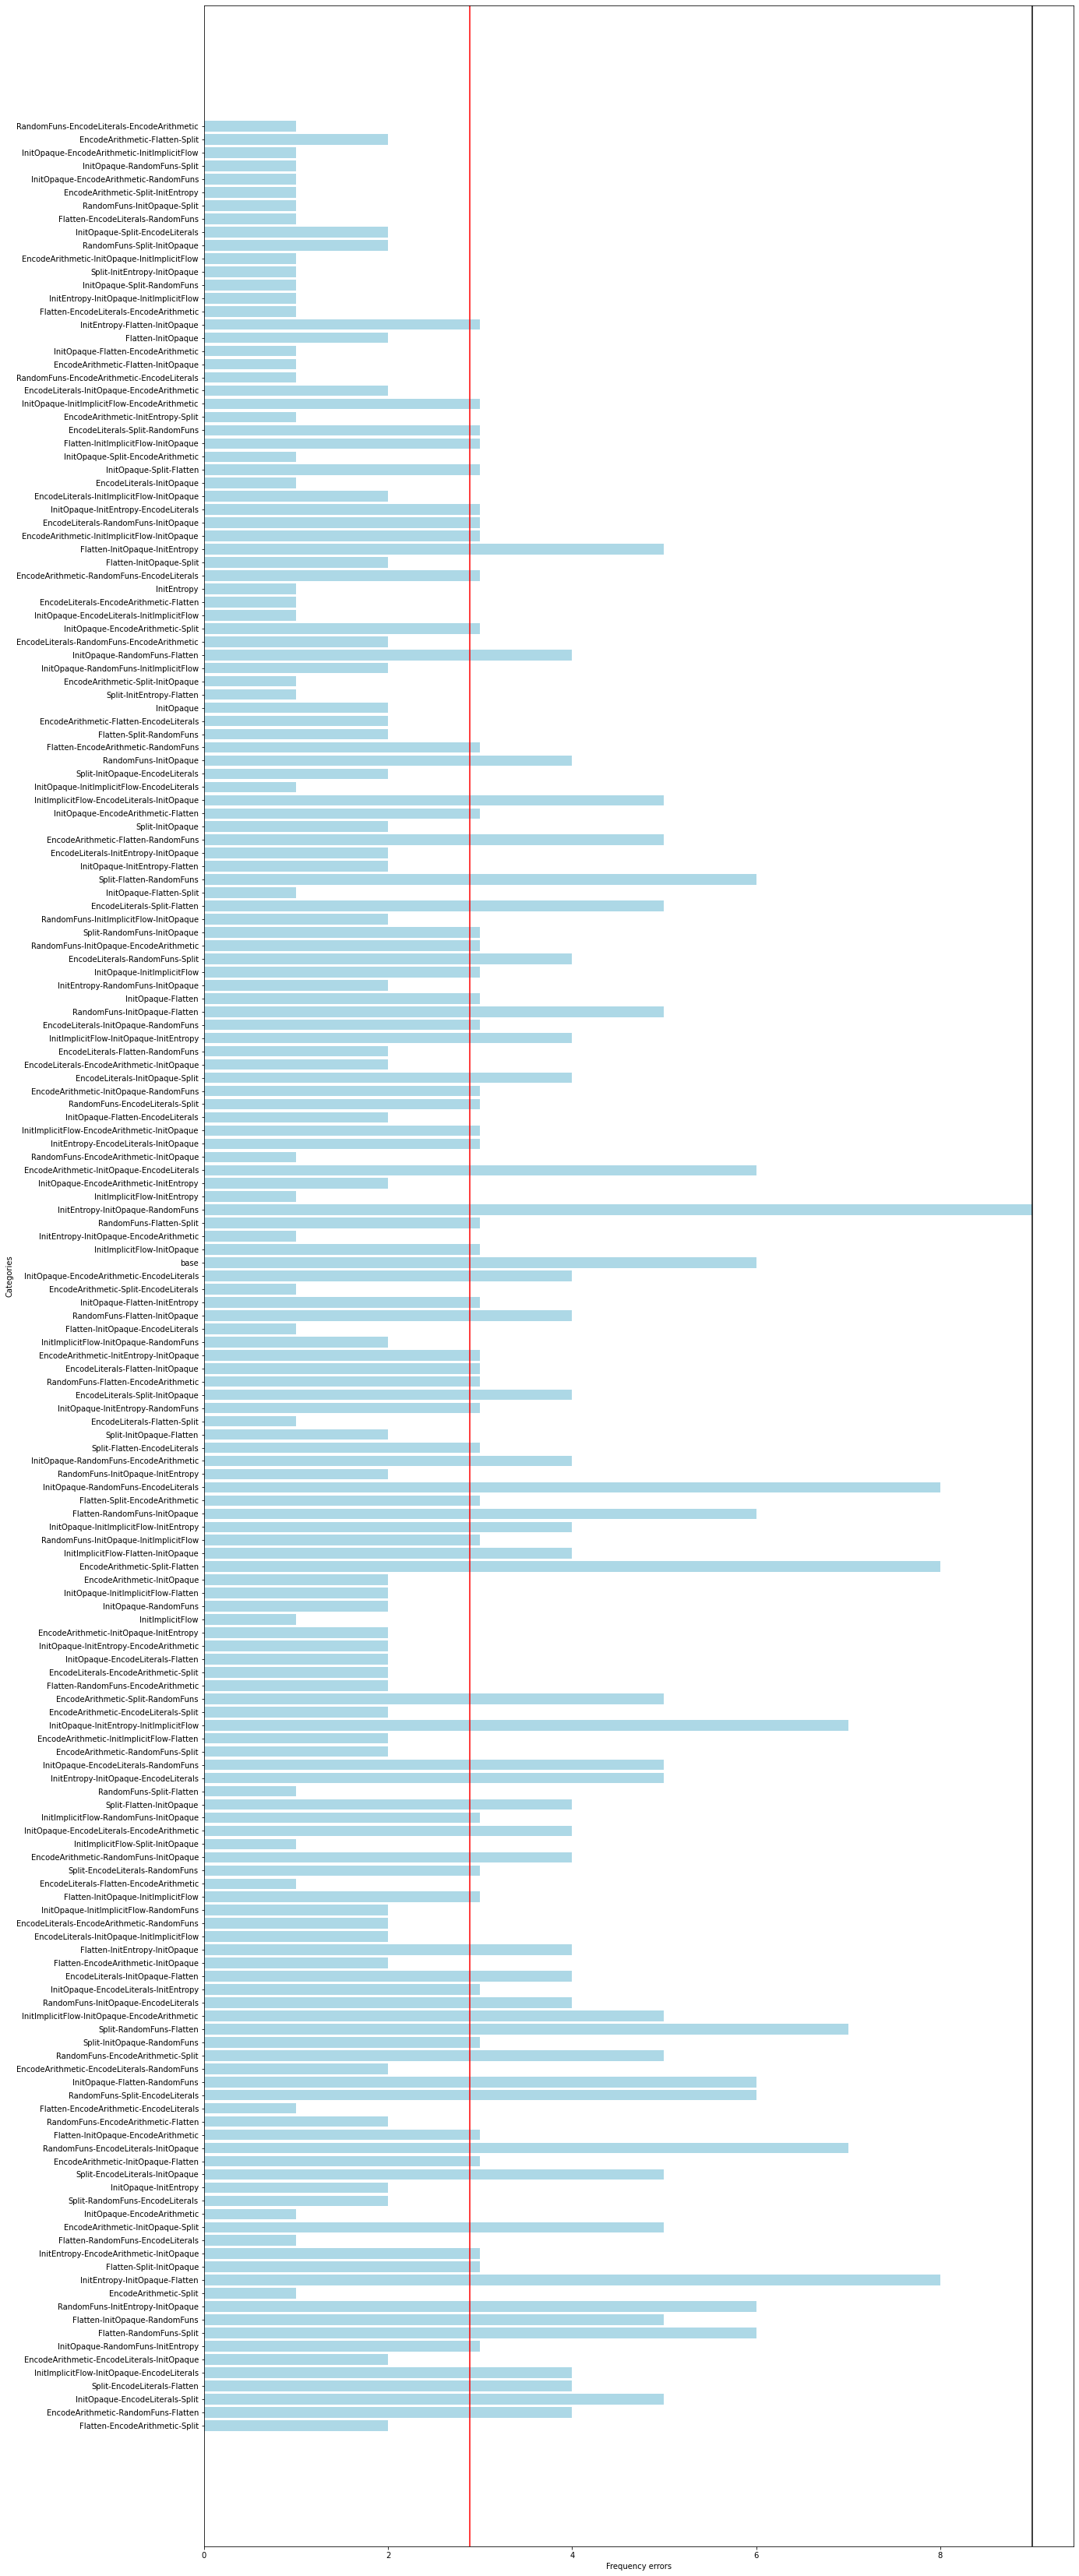


Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione


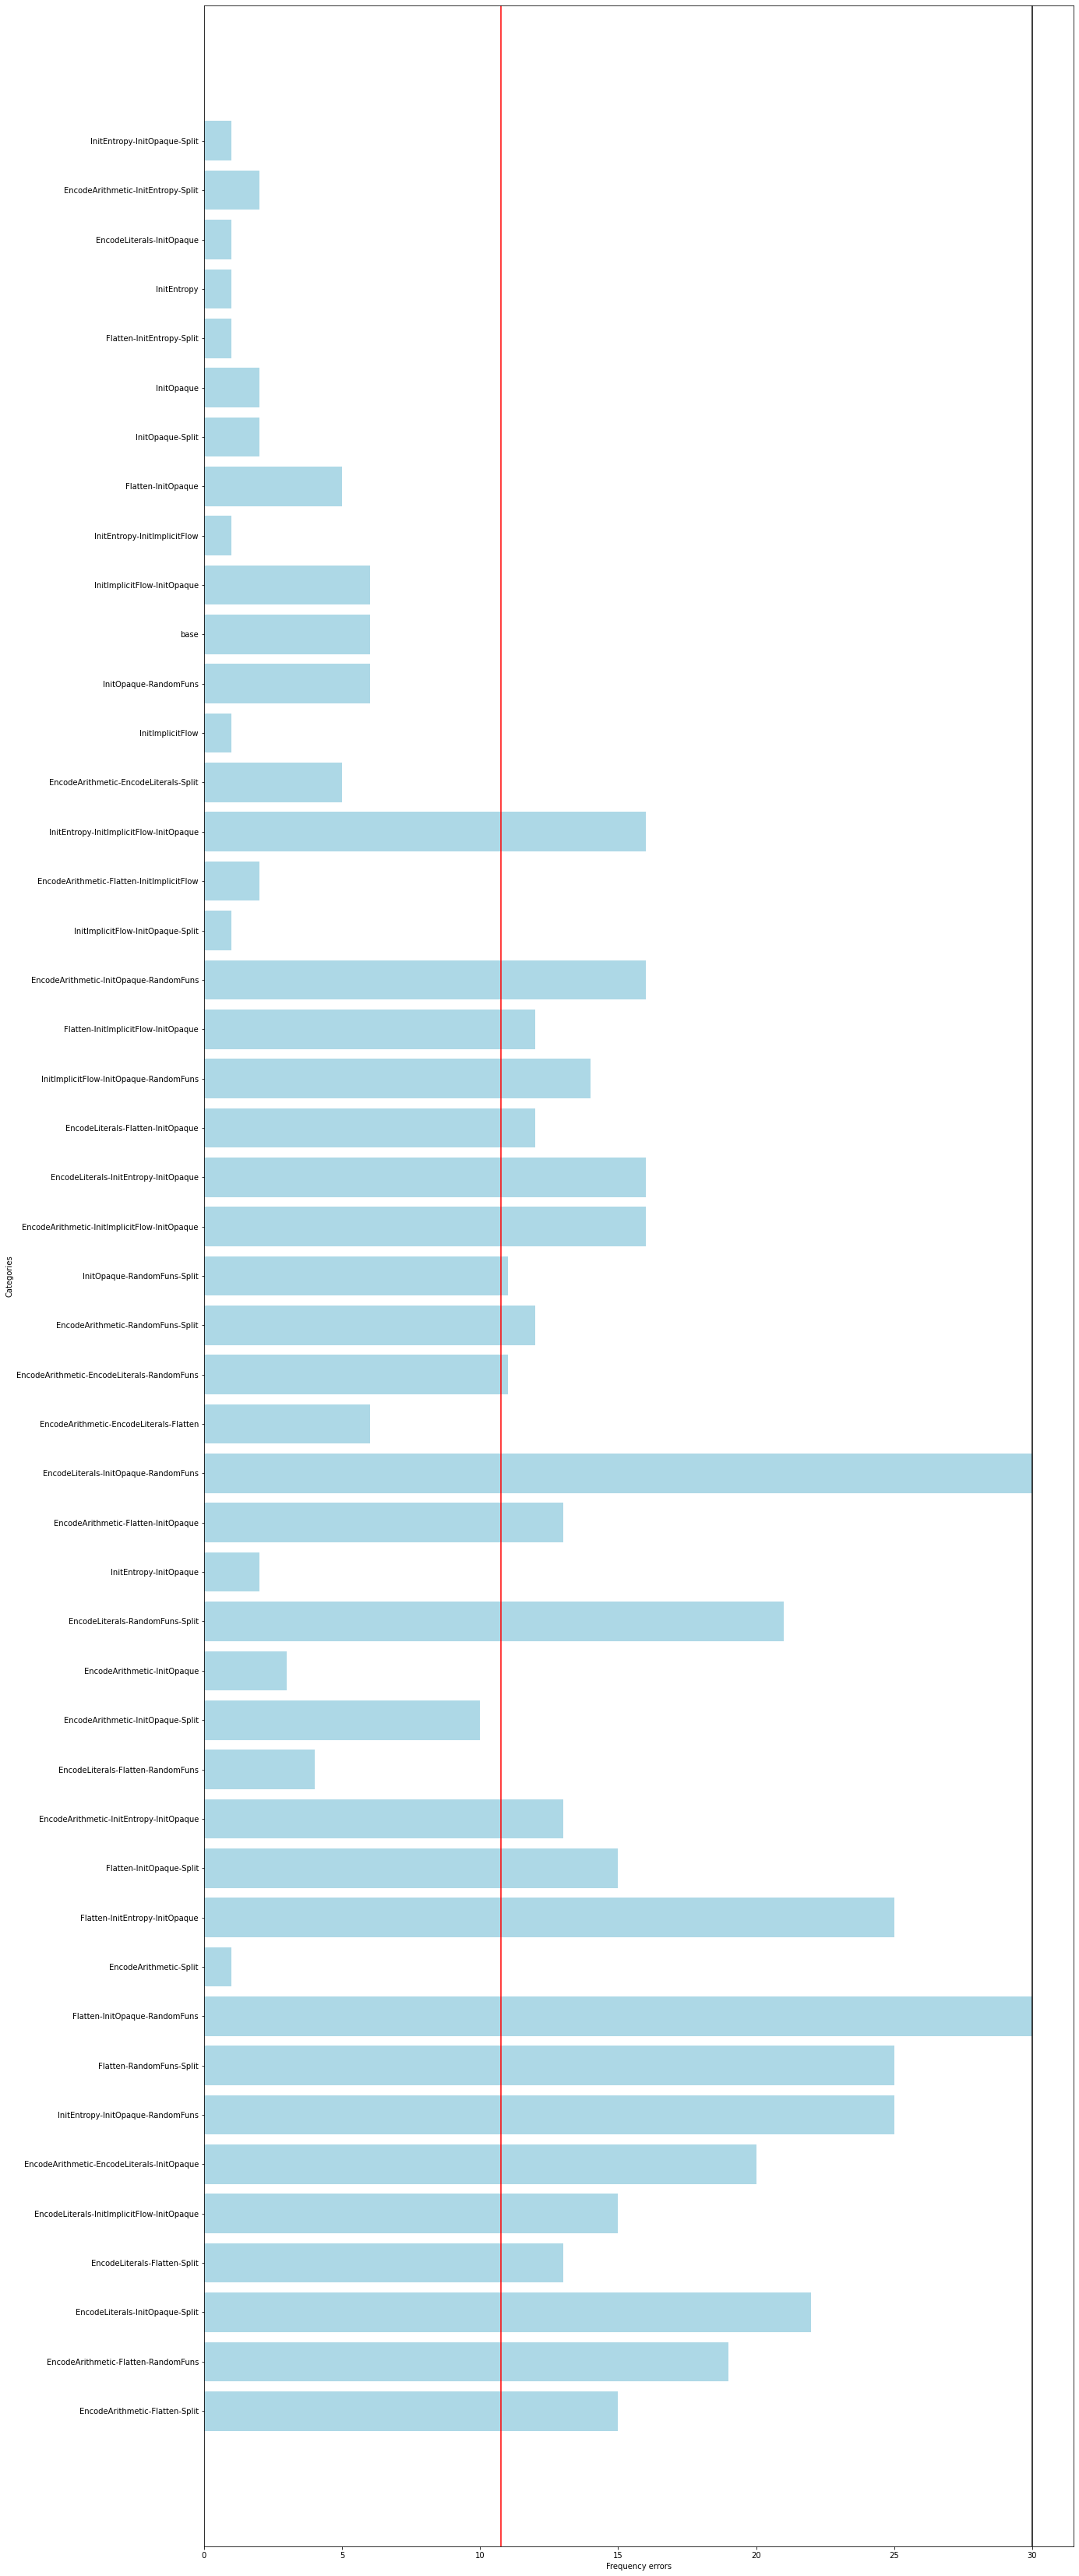


Grafo degli errori per classe


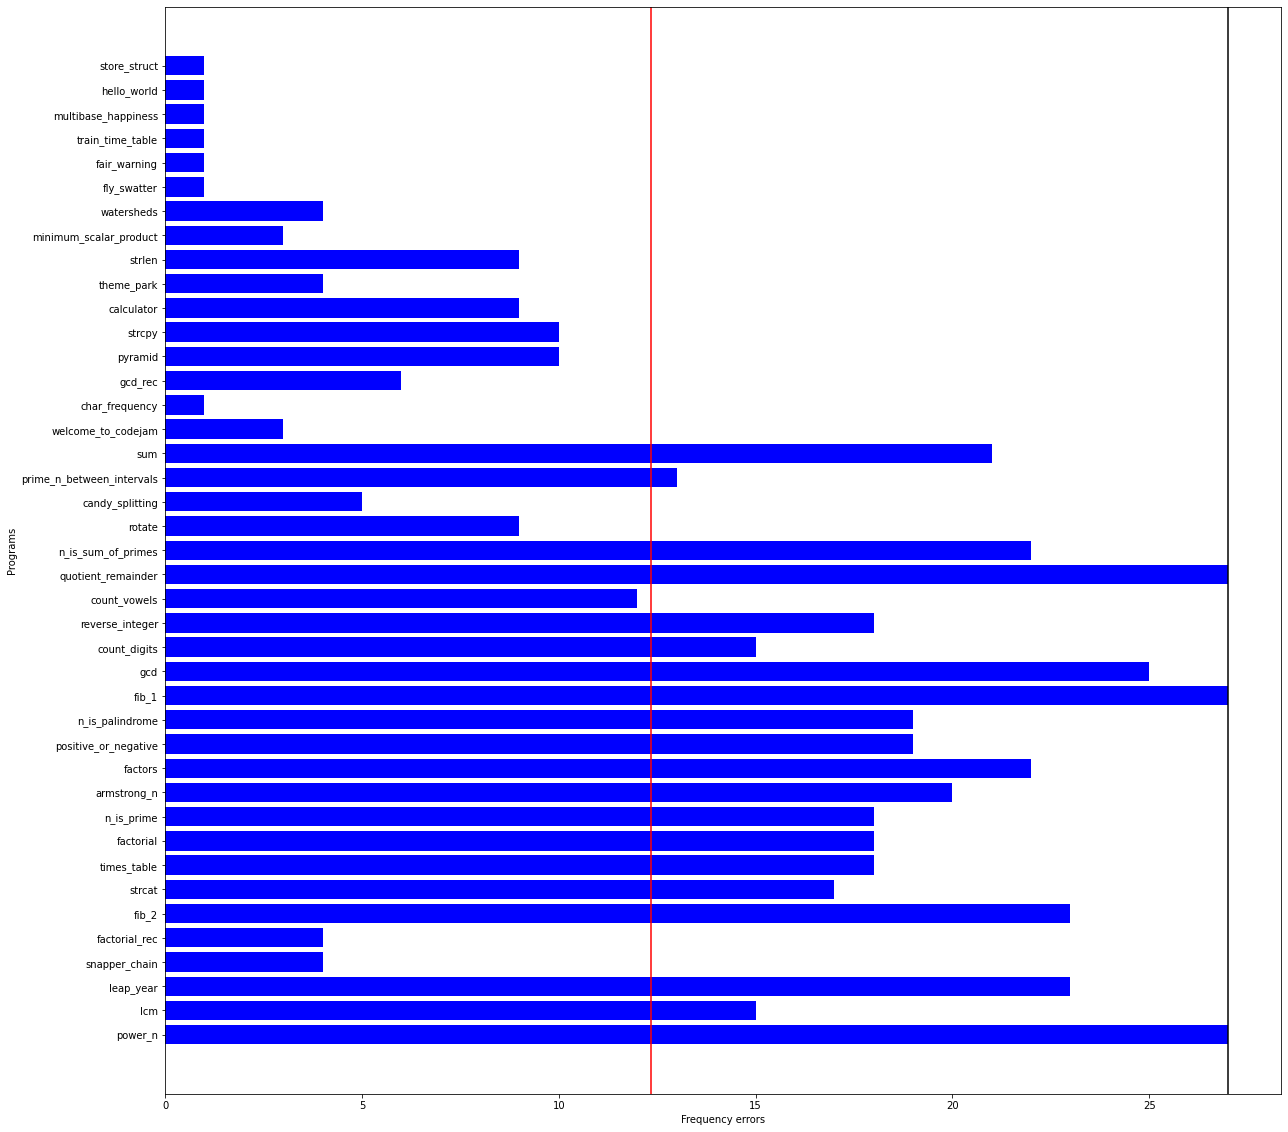


Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero


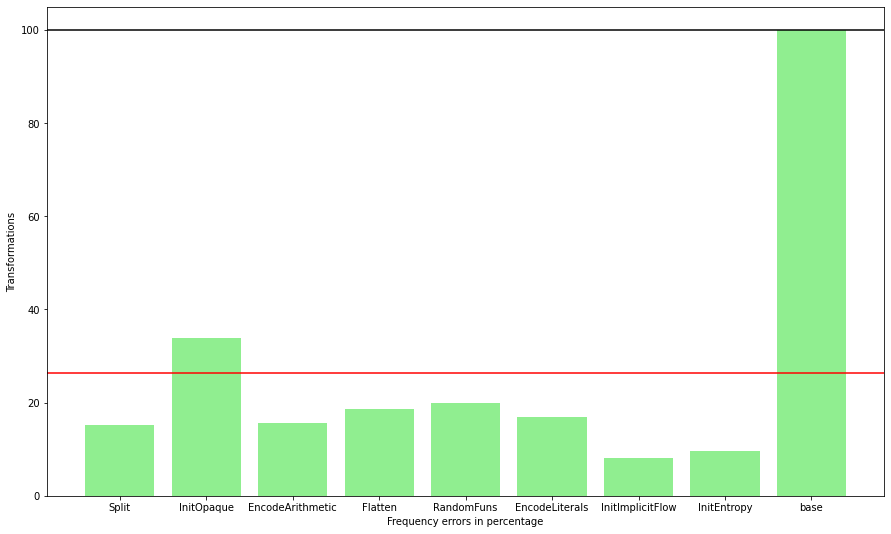

In [36]:
count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelLSTM3, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
img_wrongObf_3 = my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue")
plt.show(img_wrongObf_3)
print()

print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
img_count_ord_wrObfs_3 = my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue")
plt.show(img_count_ord_wrObfs_3)
print()

print("Grafo degli errori per classe")
img_count_WrongClasses_3 = my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue")
plt.show(img_count_WrongClasses_3)
print()

print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
img_sing_wrObf_perc_3 = my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen")
plt.show(img_sing_wrObf_perc_3)

In [37]:
#Ordina e ritorna una lista
ordered_set_obfs = count_ordered_wr_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('Flatten-InitOpaque-RandomFuns', 30)
('EncodeLiterals-InitOpaque-RandomFuns', 30)
('InitEntropy-InitOpaque-RandomFuns', 25)
('Flatten-RandomFuns-Split', 25)
('Flatten-InitEntropy-InitOpaque', 25)
('EncodeLiterals-InitOpaque-Split', 22)
('EncodeLiterals-RandomFuns-Split', 21)
('EncodeArithmetic-EncodeLiterals-InitOpaque', 20)
('EncodeArithmetic-Flatten-RandomFuns', 19)
('EncodeArithmetic-InitImplicitFlow-InitOpaque', 16)
('EncodeLiterals-InitEntropy-InitOpaque', 16)
('EncodeArithmetic-InitOpaque-RandomFuns', 16)
('InitEntropy-InitImplicitFlow-InitOpaque', 16)
('EncodeArithmetic-Flatten-Split', 15)
('EncodeLiterals-InitImplicitFlow-InitOpaque', 15)
('Flatten-InitOpaque-Split', 15)
('InitImplicitFlow-InitOpaque-RandomFuns', 14)
('EncodeLiterals-Flatten-Split', 13)
('EncodeArithmetic-InitEntropy-InitOpaque', 13)
('EncodeArithmetic-Flatten-InitOpaque', 13)
('EncodeArithmetic-RandomFuns-Split', 12)
('EncodeLiterals-Flatten-InitOpaque', 12)
('Flatten-InitImplicitFlow-InitOpaque', 12)
('Encod

In [38]:
ordered_tot = my_lib.order_dict_of_dict(percent_wr_classeXobf_tot)
print("Classi - percentuale su tutto test set")
my_lib.stampa_percent_classeXobf(ordered_tot)

Classi - percentuale su tutto test set
power_n := InitOpaque: 91.67%; Flatten: 43.48%; RandomFuns: 42.31%; Split: 38.1%; EncodeArithmetic: 37.5%; EncodeLiterals: 33.33%; InitEntropy: 33.33%; InitImplicitFlow: 13.64%; 
lcm := InitOpaque: 69.23%; EncodeArithmetic: 50.0%; RandomFuns: 36.36%; Split: 30.77%; EncodeLiterals: 25.0%; Flatten: 23.08%; InitImplicitFlow: 20.0%; InitEntropy: 5.26%; 
leap_year := InitOpaque: 76.0%; RandomFuns: 46.15%; EncodeArithmetic: 36.36%; Flatten: 35.0%; InitEntropy: 31.82%; InitImplicitFlow: 28.57%; EncodeLiterals: 24.0%; Split: 15.38%; 
snapper_chain := base: 100.0%; EncodeLiterals: 14.29%; Split: 10.0%; Flatten: 8.0%; InitEntropy: 5.0%; InitOpaque: 4.76%; 
factorial_rec := InitOpaque: 20.0%; EncodeLiterals: 15.79%; Flatten: 11.11%; InitImplicitFlow: 6.67%; Split: 6.67%; EncodeArithmetic: 4.55%; RandomFuns: 4.17%; 
fib_2 := InitOpaque: 78.57%; Split: 53.85%; EncodeLiterals: 48.0%; RandomFuns: 34.62%; EncodeArithmetic: 25.0%; Flatten: 25.0%; InitImplicitFlow:

#Confronti

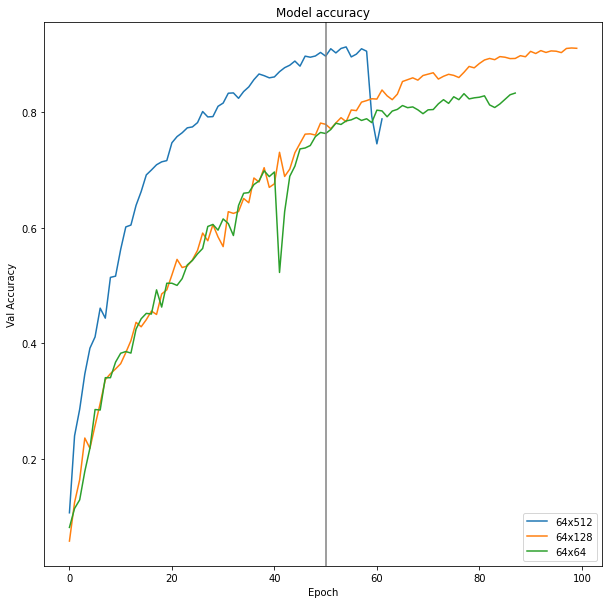

In [53]:
#Plot training & validation accuracy values
plt.figure(figsize=(10, 10))
plt.plot(hist.history['val_acc'])
plt.plot(hist2.history['val_acc'])
plt.plot(hist3.history['val_acc'])
plt.axvline(50, color="grey") # Horizontal line adding the threshold
plt.title('Model accuracy')
plt.ylabel('Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['64x512', '64x128', '64x64'], loc='lower right')
plt.show()